### Business Problem

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
**For many incumbent operators, retaining high profitable customers is the number one business goal.**

**To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.**

### Objective

In this project, we will 
* analyze customer-level data of a leading telecom firm, 
* identify the main indicators of churn.
* build predictive models to identify customers at high risk of churn. 

#### Churn Definition

This project is based on Indian and Southeast Asian market and following **Usage-based Churn definition** will be used:

*Usage-based churn:Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.*

#### High Value Churn

In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

#### Data and Business Objective

**dataset**: The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively.

**business objective**: is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. 

####  Understanding Customer Behaviour during Churn

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

1. The **‘good’ phase**: In this phase, the customer is happy with the service and behaves as usual.

2. The **‘action’ phase**: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. The **‘churn’ phase**: In this phase, the customer is said to have churned. We define churn based on this phase.

In this project, since we are working over a four-month window:
* the first two months (6th and 7th month data) are the ‘good’ phase, 
* the third month (8th month) is the ‘action’ phase, 
* while the fourth month (9th month) is the ‘churn’ phase.

### Approach and solution

The following approach was followed for churn modeling:

1. Data extraction, cleaning and Exploratory Data Analysis.
2. From above steps useful patterns were identified, in particular a significant drop in many features was observed during action phase.
3. Handling of missing values and outliers treatment.
4. Relationships among different features were also identified during EDA phase, and feature for which there were component features present in the data set were dropped.
3. Feature engineering was done, in particular the following broad steps were taken:
   * New features were created for good phase by taking the average of 6th and 7th month values.
   * New features were derived from date related values.
   * New features were derived in action phase by taking the difference between good phase and 8th month corresponding features.
4. Feature standardization and scaling.
5. As the data set is highly imbalanced towards the 'Non-churn' majority class, imbalanced data set handling was done, specifically the following two techniques were followed.
    * SMOTE: synthetic sample generation for minority class.
    * Majority class under sampling.
6. From above majority class under sampling gave better results and hence was used for final model building. Data was divided into training and test set.
7. Basic model was created using Logistic Regression.
8. As churn prediction is primary motive **sensitivity and f1 score** were looked into to be maximized.
9. Feature reduction was done using PCA (the reduced feature set contained ~ 40 feature).
10. Baseline model was created.
11. Multiple models were tried namely - **Logistic Regression, Random Forest and XgBoost**.
12. Visualisation of Random Forest trees were used to identify the key driver variables
13. The best prediction model was obtained using XgBoost were a **sensitivity of approx. 86% a precision of 35% and f1 score of 50% was obtained**.
14. Finally recommendation were suggested for reducing churn.

# Step:0
## Importing the relevant libraries & data files 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.parser import parse
import warnings
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score,roc_auc_score,f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
import itertools

from imblearn.over_sampling import SMOTE

# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz
import os

import statsmodels.api as sm

# import xgboost libraries
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

warnings.filterwarnings('ignore')
sns.set(style='dark')
%matplotlib inline
pd.set_option("display.max_rows",250)
pd.set_option("display.max_columns",250)

Using TensorFlow backend.
C:\Softwares\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
Tele_churn = pd.read_csv('telecom_churn_data.csv',encoding="ISO-8859-1")
Tele_churn.shape

(99999, 226)

In [3]:
Tele_churn.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [4]:
#let us check if there are any missing values before going into High Value customers
100*Tele_churn.isnull().sum()/len(Tele_churn.index)

mobile_number                0.000000
circle_id                    0.000000
loc_og_t2o_mou               1.018010
std_og_t2o_mou               1.018010
loc_ic_t2o_mou               1.018010
last_date_of_month_6         0.000000
last_date_of_month_7         0.601006
last_date_of_month_8         1.100011
last_date_of_month_9         1.659017
arpu_6                       0.000000
arpu_7                       0.000000
arpu_8                       0.000000
arpu_9                       0.000000
onnet_mou_6                  3.937039
onnet_mou_7                  3.859039
onnet_mou_8                  5.378054
onnet_mou_9                  7.745077
offnet_mou_6                 3.937039
offnet_mou_7                 3.859039
offnet_mou_8                 5.378054
offnet_mou_9                 7.745077
roam_ic_mou_6                3.937039
roam_ic_mou_7                3.859039
roam_ic_mou_8                5.378054
roam_ic_mou_9                7.745077
roam_og_mou_6                3.937039
roam_og_mou_

In [5]:
#Missing values which are greater than 70 percent
df1 = pd.DataFrame(100*Tele_churn.isnull().sum()/len(Tele_churn.index))
df1.columns = ['percen']
df1[df1['percen']>70]

,percen
date_of_last_rech_data_6,74.846748
date_of_last_rech_data_7,74.428744
date_of_last_rech_data_8,73.660737
date_of_last_rech_data_9,74.077741
total_rech_data_6,74.846748
total_rech_data_7,74.428744
total_rech_data_8,73.660737
total_rech_data_9,74.077741
max_rech_data_6,74.846748
max_rech_data_7,74.428744


#### Even though there are 74% missing values on the columns used for High value customers, we can't derive the nearest value and hence moving forward with substituting Zero values for those specific fields



# Step 1

## Filter high-value customers

In [6]:
#Tele_churn.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'], axis=1, inplace=True)
#Tele_churn = Tele1

#Checking for NA in COLUMNS RELEVANT FOR High Value Customer identification 
numeric_column = ['total_rech_amt_6','total_rech_amt_7', 'total_rech_amt_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_9']
Tele_churn[numeric_column] = Tele_churn[numeric_column].replace(np.nan, 0)
print('There are NULL/NA values in columns related to High value customers derivation: ', Tele_churn[numeric_column].isnull().values.any())

There are NULL/NA values in columns related to High value customers derivation:  False


In [7]:
Tele_churn['HVC_FLG'] = 1

Tele_churn['total_avg_rech_amt_good_ph'] = (Tele_churn['total_rech_amt_6']+(Tele_churn['av_rech_amt_data_6']*Tele_churn['total_rech_data_6']) + Tele_churn['total_rech_amt_7']+(Tele_churn['av_rech_amt_data_7']*Tele_churn['total_rech_data_7']))/2

def HVC_flag(x, y):
    if x >= y:
        return 0
    return 1 

num = Tele_churn['total_avg_rech_amt_good_ph'].describe(percentiles=[.70])['70%']
Tele_churn['HVC_FLG'] = Tele_churn.apply(lambda x: HVC_flag(x['total_avg_rech_amt_good_ph'], num), axis=1)
Tele_churn = Tele_churn[Tele_churn['HVC_FLG']==0]
print('Total High Value Customers identified: ', len(Tele_churn))

Tele_churn.drop(['HVC_FLG'], axis=1, inplace=True)

Total High Value Customers identified:  30001


# Step 2

## Churn Identification for selected 30001 customers filtered above

In [8]:
numeric_column = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
Tele_churn[numeric_column] = Tele_churn[numeric_column].replace(np.nan, 0)
print('There are NULL/NA values in columns related to Churner derivation: ', Tele_churn[numeric_column].isnull().values.any())

There are NULL/NA values in columns related to Churner derivation:  False


In [9]:
Tele_churn['churn'] = 1
def CHURN_flag(x):
    if x > 0:
        return 0  
    return 1
Tele_churn[Tele_churn['total_ic_mou_9']+ Tele_churn['total_og_mou_9'] + Tele_churn['vol_2g_mb_9']+ Tele_churn['vol_3g_mb_9']==0]
Tele_churn['churn'] = Tele_churn.apply(lambda x: CHURN_flag(x['total_ic_mou_9']+ x['total_og_mou_9'] + x['vol_2g_mb_9']+ x['vol_3g_mb_9']), axis=1)
print('Total Not Churn Customers identified: ', len(Tele_churn[Tele_churn['churn']==0]))
print('Total Churn Customers identified: ', len(Tele_churn[Tele_churn['churn']==1]))

Total Not Churn Customers identified:  27560
Total Churn Customers identified:  2441


In [10]:
#Deleting all columns with _9
cols_9 = [col for col in Tele_churn.columns if '_9' in col]
Tele_churn.drop(cols_9, axis=1, inplace=True)
print(len(Tele_churn.columns))

174


#### Calculating missing values before getting EDA for these filtered customers

In [11]:
df2 = pd.DataFrame(100*Tele_churn.isnull().sum()/len(Tele_churn.index))
df2.columns = ['percen']
df2[df2['percen']>20]

,percen
date_of_last_rech_data_6,44.148528
date_of_last_rech_data_7,43.145228
date_of_last_rech_data_8,46.825106
total_rech_data_8,46.825106
max_rech_data_6,44.148528
max_rech_data_7,43.145228
max_rech_data_8,46.825106
count_rech_2g_6,44.148528
count_rech_2g_7,43.145228
count_rech_2g_8,46.825106


# Step 3
## Imputing values using KNN for Boolean missing critical elements (Night pack & FB users) only which other's would be replaced wiht zeros

In [12]:
Tele1=Tele_churn

In [13]:
def find_KNN(X, y, x_valid, y_valid, neigh):
    X = X.fillna(0)
    x_valid = x_valid.fillna(0)
    y_valid.columns = ['KNN_value']
    train_pct_index = int(0.8 * len(X))
    X_train, X_test = X[:train_pct_index], X[train_pct_index:]
    y_train, y_test = y[:train_pct_index], y[train_pct_index:]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #split dataset into train and test data
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # Create KNN classifier
    knn = KNeighborsClassifier(n_neighbors = neigh)
    # Fit the classifier to the data
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    #print(confusion_matrix(y_test, y_pred))
    #check accuracy of our model on the test data
    print('Accuracy Score for Predicted values:', knn.score(X_test, y_test))
    predict_list = knn.predict(x_valid)
    # iterating over rows using iterrows() function
    a=0
    for index, row in y_valid.iterrows(): 
        y_valid['KNN_value'][index] = predict_list[a] 
        a=a+1 
    return y_valid

In [14]:
#KNN for night_pck_user_6
Tele6 = Tele1[['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6','loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_t2c_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6',  'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_t2o_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'last_day_rch_amt_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'arpu_3g_6', 'arpu_2g_6', 'aon', 'jun_vbc_3g', 'night_pck_user_6']]
X1=Tele6[Tele6['night_pck_user_6'].isnull()==False]
y1=X1[['night_pck_user_6']]
X1 = X1[['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6','loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_t2c_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6',  'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_t2o_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'last_day_rch_amt_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'arpu_3g_6', 'arpu_2g_6', 'aon', 'jun_vbc_3g']]

x_valid1=Tele6[Tele6['night_pck_user_6'].isnull()==True]
y_valid1=x_valid1[['night_pck_user_6']]
x_valid1 = x_valid1[['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6','loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_t2c_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6',  'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_t2o_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'last_day_rch_amt_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'arpu_3g_6', 'arpu_2g_6', 'aon', 'jun_vbc_3g']]

df_temp6 = find_KNN(X1, y1, x_valid1, y_valid1, 2)


Tele1 = Tele1.join(df_temp6)
Tele1['KNN_value'] = Tele1['KNN_value'].fillna(0)
Tele1['night_pck_user_6']= Tele1['night_pck_user_6'].fillna(0)
Tele1['night_pck_user_6'] = Tele1['night_pck_user_6'] + Tele1['KNN_value']
Tele1.drop('KNN_value', axis=1, inplace=True)
len(Tele1.query('night_pck_user_6!=0 & night_pck_user_6!=1'))

Accuracy Score for Predicted values: 0.9770286396181385


0

In [15]:
#KNN for night_pck_user_7

Tele7 = Tele1[['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7','loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_t2c_mou_7', 'std_og_mou_7', 'isd_og_mou_7', 'spl_og_mou_7', 'og_others_7',  'total_og_mou_7', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_mou_7', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7', 'std_ic_t2o_mou_7', 'std_ic_mou_7', 'total_ic_mou_7', 'spl_ic_mou_7', 'isd_ic_mou_7', 'ic_others_7', 'total_rech_num_7', 'total_rech_amt_7', 'max_rech_amt_7', 'last_day_rch_amt_7', 'total_rech_data_7', 'max_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'vol_2g_mb_7', 'vol_3g_mb_7', 'arpu_3g_7', 'arpu_2g_7', 'aon', 'jul_vbc_3g', 'night_pck_user_7']]
X1=Tele7[Tele7['night_pck_user_7'].isnull()==False]
y1=X1[['night_pck_user_7']]
X1 = X1[['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7','loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_t2c_mou_7', 'std_og_mou_7', 'isd_og_mou_7', 'spl_og_mou_7', 'og_others_7',  'total_og_mou_7', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_mou_7', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7', 'std_ic_t2o_mou_7', 'std_ic_mou_7', 'total_ic_mou_7', 'spl_ic_mou_7', 'isd_ic_mou_7', 'ic_others_7', 'total_rech_num_7', 'total_rech_amt_7', 'max_rech_amt_7', 'last_day_rch_amt_7', 'total_rech_data_7', 'max_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'vol_2g_mb_7', 'vol_3g_mb_7', 'arpu_3g_7', 'arpu_2g_7', 'aon', 'jul_vbc_3g']]

x_valid1=Tele7[Tele7['night_pck_user_7'].isnull()==True]
y_valid1=x_valid1[['night_pck_user_7']]
x_valid1 = x_valid1[['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7','loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_t2c_mou_7', 'std_og_mou_7', 'isd_og_mou_7', 'spl_og_mou_7', 'og_others_7',  'total_og_mou_7', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_mou_7', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7', 'std_ic_t2o_mou_7', 'std_ic_mou_7', 'total_ic_mou_7', 'spl_ic_mou_7', 'isd_ic_mou_7', 'ic_others_7', 'total_rech_num_7', 'total_rech_amt_7', 'max_rech_amt_7', 'last_day_rch_amt_7', 'total_rech_data_7', 'max_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'vol_2g_mb_7', 'vol_3g_mb_7', 'arpu_3g_7', 'arpu_2g_7', 'aon', 'jul_vbc_3g']]

df_temp7 = find_KNN(X1, y1, x_valid1, y_valid1,2)


Tele1 = Tele1.join(df_temp7)
Tele1['KNN_value'] = Tele1['KNN_value'].fillna(0)
Tele1['night_pck_user_7']= Tele1['night_pck_user_7'].fillna(0)
Tele1['night_pck_user_7'] = Tele1['night_pck_user_7'] + Tele1['KNN_value']
Tele1.drop('KNN_value', axis=1, inplace=True)
len(Tele1.query('night_pck_user_7!=0 & night_pck_user_7!=1'))

Accuracy Score for Predicted values: 0.977725674091442


0

In [16]:
#KNN for night_pck_user_8
Tele8 = Tele1[['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8','loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_t2c_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8',  'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_t2o_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_3g_8', 'arpu_2g_8', 'aon', 'aug_vbc_3g', 'night_pck_user_8']]
X1=Tele8[Tele8['night_pck_user_8'].isnull()==False]
y1=X1[['night_pck_user_8']]
X1 = X1[['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8','loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_t2c_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8',  'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_t2o_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_3g_8', 'arpu_2g_8', 'aon', 'aug_vbc_3g']]

x_valid1=Tele8[Tele8['night_pck_user_8'].isnull()==True]
y_valid1=x_valid1[['night_pck_user_8']]
x_valid1 = x_valid1[['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8','loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_t2c_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8',  'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_t2o_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_3g_8', 'arpu_2g_8', 'aon', 'aug_vbc_3g']]

df_temp8 = find_KNN(X1, y1, x_valid1, y_valid1, 2)


Tele1 = Tele1.join(df_temp8)
Tele1['KNN_value'] = Tele1['KNN_value'].fillna(0)
Tele1['night_pck_user_8']= Tele1['night_pck_user_8'].fillna(0)
Tele1['night_pck_user_8'] = Tele1['night_pck_user_8'] + Tele1['KNN_value']
Tele1.drop('KNN_value', axis=1, inplace=True)
len(Tele1.query('night_pck_user_8!=0 & night_pck_user_8!=1'))

Accuracy Score for Predicted values: 0.980883735506111


0

In [17]:
#KNN for fb_user_6
Telefb = Tele1[['jun_vbc_3g', 'sachet_2g_6', 'sachet_3g_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'fb_user_6']]
X1=Telefb[Telefb['fb_user_6'].isnull()==False]
y1=X1[['fb_user_6']]
X1 = X1[['jun_vbc_3g', 'sachet_2g_6', 'sachet_3g_6', 'vol_2g_mb_6', 'vol_3g_mb_6']]

x_valid1=Telefb[Telefb['fb_user_6'].isnull()==True]
y_valid1=x_valid1[['fb_user_6']]
x_valid1 = x_valid1[['jun_vbc_3g', 'sachet_2g_6', 'sachet_3g_6', 'vol_2g_mb_6', 'vol_3g_mb_6']]

df_temp = find_KNN(X1, y1, x_valid1, y_valid1, 2)

Tele1 = Tele1.join(df_temp)
Tele1['KNN_value'] = Tele1['KNN_value'].fillna(0)
Tele1['fb_user_6']= Tele1['fb_user_6'].fillna(0)
Tele1['fb_user_6'] = Tele1['fb_user_6'] + Tele1['KNN_value']
Tele1.drop('KNN_value', axis=1, inplace=True)
len(Tele1.query('fb_user_6!=0 & fb_user_6!=1'))

Accuracy Score for Predicted values: 0.9800119331742243


0

In [18]:
#KNN for fb_user_7
Telefb = Tele1[['jul_vbc_3g', 'sachet_2g_7', 'sachet_3g_7', 'vol_2g_mb_7', 'vol_3g_mb_7', 'fb_user_7']]
X1=Telefb[Telefb['fb_user_7'].isnull()==False]
y1=X1[['fb_user_7']]
X1 = X1[['jul_vbc_3g', 'sachet_2g_7', 'sachet_3g_7', 'vol_2g_mb_7', 'vol_3g_mb_7']]

x_valid1=Telefb[Telefb['fb_user_7'].isnull()==True]
y_valid1=x_valid1[['fb_user_7']]
x_valid1 = x_valid1[['jul_vbc_3g', 'sachet_2g_7', 'sachet_3g_7', 'vol_2g_mb_7', 'vol_3g_mb_7']]

df_temp = find_KNN(X1, y1, x_valid1, y_valid1, 2)

Tele1 = Tele1.join(df_temp)
Tele1['KNN_value'] = Tele1['KNN_value'].fillna(0)
Tele1['fb_user_7']= Tele1['fb_user_7'].fillna(0)
Tele1['fb_user_7'] = Tele1['fb_user_7'] + Tele1['KNN_value']
Tele1.drop('KNN_value', axis=1, inplace=True)
len(Tele1.query('fb_user_7!=0 & fb_user_7!=1'))

Accuracy Score for Predicted values: 0.9721570926143025


0

In [19]:
#KNN for fb_user_8
Telefb = Tele1[['aug_vbc_3g', 'sachet_2g_8', 'sachet_3g_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'fb_user_8']]
X1=Telefb[Telefb['fb_user_8'].isnull()==False]
y1=X1[['fb_user_8']]
X1 = X1[['aug_vbc_3g', 'sachet_2g_8', 'sachet_3g_8', 'vol_2g_mb_8', 'vol_3g_mb_8']]

x_valid1=Telefb[Telefb['fb_user_8'].isnull()==True]
y_valid1=x_valid1[['fb_user_8']]
x_valid1 = x_valid1[['aug_vbc_3g', 'sachet_2g_8', 'sachet_3g_8', 'vol_2g_mb_8', 'vol_3g_mb_8']]

df_temp = find_KNN(X1, y1, x_valid1, y_valid1, 2)

Tele1 = Tele1.join(df_temp)
Tele1['KNN_value'] = Tele1['KNN_value'].fillna(0)
Tele1['fb_user_8']= Tele1['fb_user_8'].fillna(0)
Tele1['fb_user_8'] = Tele1['fb_user_8'] + Tele1['KNN_value']
Tele1.drop('KNN_value', axis=1, inplace=True)
len(Tele1.query('fb_user_8!=0 & fb_user_8!=1'))

Accuracy Score for Predicted values: 0.9771231588843623


0

In [20]:
df3 = pd.DataFrame(100*Tele1.isnull().sum()/len(Tele1.index))
df3.columns = ['percen']
df3[df3['percen']>0]

,percen
loc_og_t2o_mou,0.746642
std_og_t2o_mou,0.746642
loc_ic_t2o_mou,0.746642
last_date_of_month_7,0.089997
last_date_of_month_8,0.549982
onnet_mou_6,1.816606
onnet_mou_7,1.789940
onnet_mou_8,3.913203
offnet_mou_6,1.816606
offnet_mou_7,1.789940


#### Handling dates and converting them into number of days

In [21]:
100*Tele1.isnull().sum()/len(Tele1.index)


mobile_number                  0.000000
circle_id                      0.000000
loc_og_t2o_mou                 0.746642
std_og_t2o_mou                 0.746642
loc_ic_t2o_mou                 0.746642
last_date_of_month_6           0.000000
last_date_of_month_7           0.089997
last_date_of_month_8           0.549982
arpu_6                         0.000000
arpu_7                         0.000000
arpu_8                         0.000000
onnet_mou_6                    1.816606
onnet_mou_7                    1.789940
onnet_mou_8                    3.913203
offnet_mou_6                   1.816606
offnet_mou_7                   1.789940
offnet_mou_8                   3.913203
roam_ic_mou_6                  1.816606
roam_ic_mou_7                  1.789940
roam_ic_mou_8                  3.913203
roam_og_mou_6                  1.816606
roam_og_mou_7                  1.789940
roam_og_mou_8                  3.913203
loc_og_t2t_mou_6               1.816606
loc_og_t2t_mou_7               1.789940


In [22]:
# extract other date columns for formating and deriving new columns
date_columns = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6',
                'date_of_last_rech_data_7', 'date_of_last_rech_data_8']

# convert to datetime
for date_col in list(date_columns):
    Tele1[date_col]= pd.to_datetime(Tele1[date_col])

# let's extract the day of last recharge
Tele1['day_of_last_rech_6'] =  Tele1.date_of_last_rech_6.dt.day
Tele1['day_of_last_rech_7'] =  Tele1.date_of_last_rech_7.dt.day
Tele1['day_of_last_rech_8'] =  Tele1.date_of_last_rech_8.dt.day

Tele1['day_of_last_rech_data_6'] =  Tele1.date_of_last_rech_data_6.dt.day
Tele1['day_of_last_rech_data_7'] =  Tele1.date_of_last_rech_data_7.dt.day
Tele1['day_of_last_rech_data_8'] =  Tele1.date_of_last_rech_data_8.dt.day

Tele1.drop([ 'date_of_last_rech_6','date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6',
            'date_of_last_rech_data_7', 'date_of_last_rech_data_8'], axis=1, inplace=True)
Tele1.drop(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8'], axis=1, inplace=True)

#### Handling all other NULL values to be replaced with Zero

In [23]:
#Handling categorical variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
boolean_column = ['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'churn']
numeric_column = list(Tele1.select_dtypes(include=numerics).columns)
numeric_column = [item for item in numeric_column if item not in boolean_column]

print('NUMERIC COLUMNS', '\n', numeric_column,'\n' )
print('BOOLEAN COLUMNS', '\n', boolean_column,'\n')

NUMERIC COLUMNS 
 ['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 

In [24]:
#Replacing all numeric null values to ZERO
print(100*Tele1[boolean_column].isnull().sum()/len(Tele1.index))
Tele1[numeric_column] = Tele1[numeric_column].replace(np.nan, 0)
print(100*Tele1[numeric_column].isnull().sum()/len(Tele1.index))


monthly_2g_6        0.0
monthly_2g_7        0.0
monthly_2g_8        0.0
monthly_3g_6        0.0
monthly_3g_7        0.0
monthly_3g_8        0.0
night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
sachet_2g_6         0.0
sachet_2g_7         0.0
sachet_2g_8         0.0
sachet_3g_6         0.0
sachet_3g_7         0.0
sachet_3g_8         0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
churn               0.0
dtype: float64
mobile_number                 0.0
circle_id                     0.0
loc_og_t2o_mou                0.0
std_og_t2o_mou                0.0
loc_ic_t2o_mou                0.0
arpu_6                        0.0
arpu_7                        0.0
arpu_8                        0.0
onnet_mou_6                   0.0
onnet_mou_7                   0.0
onnet_mou_8                   0.0
offnet_mou_6                  0.0
offnet_mou_7                  0.0
offnet_mou_8                  0.0
roam_ic_mou_6                 0.0
roam_ic_mou_7      

#### Now the dataframe is all set for EDA steps 

In [25]:
telecom_data =  Tele1
Tele_churn = Tele1 

# Step 4
## Exploratory Data Analysis 

In [26]:
# create function to anlyze the features across 6th, 7th and 8th month
def analyze_feature(feature_start):
    plt.rcParams["figure.figsize"] = [17, 7]
    fig = plt.figure()
    print("Churn Stats (mean and standard deviation):")
    cols = {c: feature_start + "_" + str(c) for c in [6,7,8]}
    print(cols)
    frame_data = []
    [frame_data.append({
        "mean_6": telecom_data[telecom_data["churn"] == churn][cols[6]].mean(),
        "mean_7": telecom_data[telecom_data["churn"] == churn][cols[7]].mean(),
        "mean_8": telecom_data[telecom_data["churn"] == churn][cols[8]].mean(),
        "std_6": telecom_data[telecom_data["churn"] == churn][cols[6]].std(),
        "std_7": telecom_data[telecom_data["churn"] == churn][cols[7]].std(),
        "std_8": telecom_data[telecom_data["churn"] == churn][cols[8]].std()
    }) for churn in [0,1]]
    
    f,axes = plt.subplots(nrows=1, ncols=3)
    sns.boxplot(data=telecom_data, y=feature_start + "_6", x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[0])
    sns.boxplot(data=telecom_data, y=feature_start + "_7",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[1])
    sns.boxplot(data=telecom_data, y=feature_start + "_8",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[2])
    return pd.DataFrame(frame_data,index={"Non Churned","Churned"}).round(2)

#### Recharge amount related variables


In [27]:
#let's again extract the recharge amount related columns
recharge_amnt_columns =  telecom_data.columns[telecom_data.columns.str.contains('rech_amt')]
recharge_amnt_columns

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'total_avg_rech_amt_good_ph'],
      dtype='object')

Churn Stats (mean and standard deviation):
{6: 'total_rech_amt_6', 7: 'total_rech_amt_7', 8: 'total_rech_amt_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,649.57,663.53,613.70,547.70,574.16,614.83
Churned,786.71,626.29,253.15,681.56,667.94,452.36


<Figure size 1224x504 with 0 Axes>

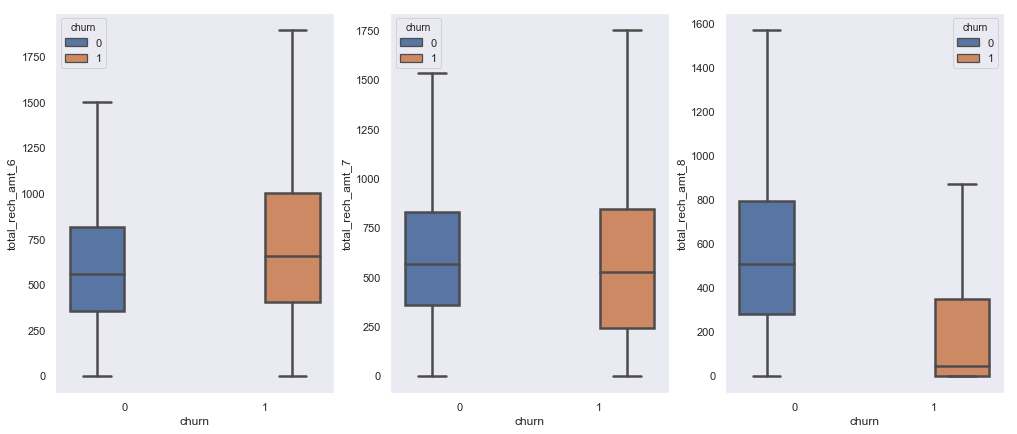

In [28]:
# let's analyze total recharge amount:
analyze_feature('total_rech_amt')

Churn Stats (mean and standard deviation):
{6: 'total_rech_amt_data_6', 7: 'total_rech_amt_data_7', 8: 'total_rech_amt_data_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,460.08,545.06,496.89,1446.36,1498.87,1683.03
Churned,407.23,338.29,83.52,1055.94,1171.76,476.78


<Figure size 1224x504 with 0 Axes>

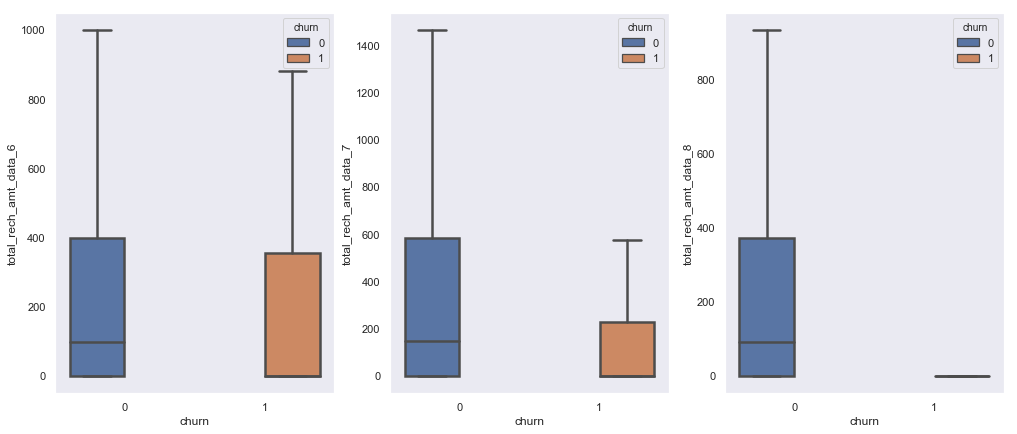

In [29]:
# let's add a new derived variable total recharge amount for data: total_rech_amt_data
telecom_data['total_rech_amt_data_6'] = telecom_data.av_rech_amt_data_6*telecom_data.total_rech_data_6
telecom_data['total_rech_amt_data_7'] = telecom_data.av_rech_amt_data_7*telecom_data.total_rech_data_7
telecom_data['total_rech_amt_data_8'] = telecom_data.av_rech_amt_data_8*telecom_data.total_rech_data_8

# let's analyze total recharge amount for data:
analyze_feature('total_rech_amt_data')

Churn Stats (mean and standard deviation):
{6: 'max_rech_amt_6', 7: 'max_rech_amt_7', 8: 'max_rech_amt_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,169.05,173.34,166.77,172.00,176.75,171.34
Churned,171.94,159.39,85.37,209.12,226.97,176.65


<Figure size 1224x504 with 0 Axes>

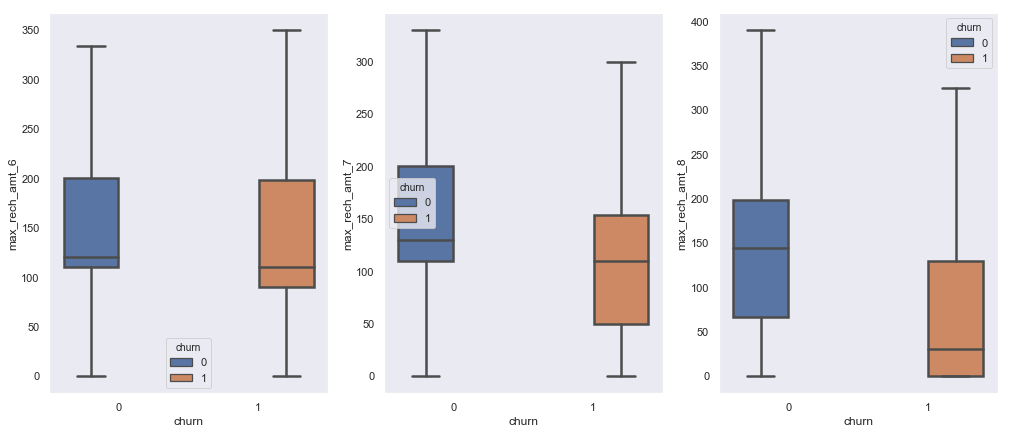

In [30]:
# let's analyze maximum recharge amount for data:
analyze_feature('max_rech_amt')

In [31]:
telecom_data['total_rech_amt_good_ph'] = (telecom_data.total_rech_amt_6 + telecom_data.total_rech_amt_7)/2
telecom_data['total_rech_amt_data_good_ph'] = (telecom_data.total_rech_amt_data_6 + telecom_data.total_rech_amt_data_7)/2
telecom_data['max_rech_amt_good_ph'] = (telecom_data.max_rech_amt_6 + telecom_data.max_rech_amt_7)/2

Churn Stats (mean and standard deviation):
{6: 'last_day_rch_amt_6', 7: 'last_day_rch_amt_7', 8: 'last_day_rch_amt_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,100.59,102.28,97.42,140.81,139.57,145.53
Churned,104.36,78.68,35.68,173.41,153.83,128.25


<Figure size 1224x504 with 0 Axes>

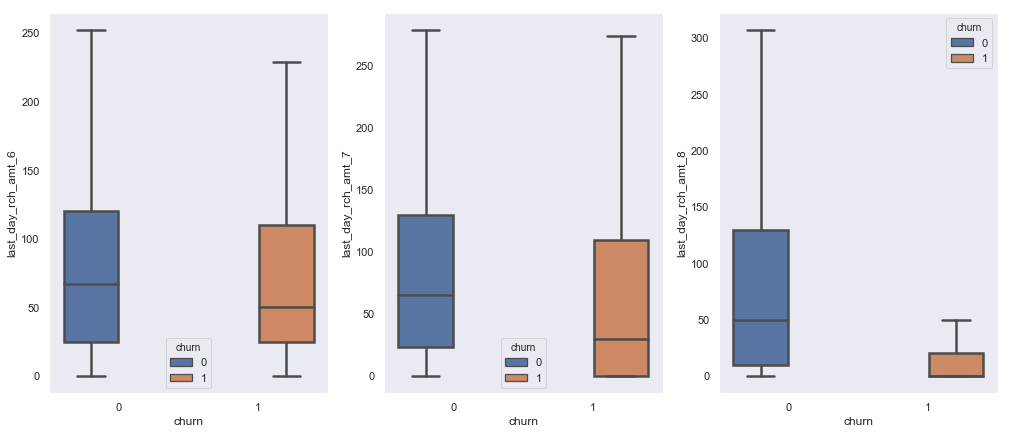

In [32]:
#let's extract the last day recharge amount columns
last_day_rech_amt = telecom_data.columns[telecom_data.columns.str.contains('day')]
# let's check the mean variation in last day recharge for churned and non churned customers
analyze_feature('last_day_rch_amt')

In [33]:
# Let us define new derived column
# last day recharge amount for good phase: last_day_rch_amt_good_ph
telecom_data['last_day_rch_amt_good_ph'] = (telecom_data.last_day_rch_amt_6 + telecom_data.last_day_rch_amt_7)/2
# Let's check other recharge related variables:
ls_recharge = telecom_data.columns[telecom_data.columns.str.contains('rech_num|max_rech_data',regex=True)]

In [34]:
# let's check the distribution for max_rech_data
telecom_data.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,30001.000000,30001.000000,30001.000000
mean,78.079564,79.841805,72.492917
std,112.731468,114.273245,110.567519
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,25.000000,25.000000,23.000000
75%,154.000000,154.000000,154.000000
max,1555.000000,1555.000000,1555.000000


In [35]:
# Let us define new derived column
# maximum recharge for data for good phase: max_rech_data_good_ph
telecom_data['max_rech_data_good_ph'] = (telecom_data.max_rech_data_6 + telecom_data.max_rech_data_7)/2

In [36]:
# let's check total recharge number
ls_tot_recharge_num = telecom_data.columns[telecom_data.columns.str.contains('total_rech_num')]

# check the summary stats:
print(telecom_data.loc[:,ls_tot_recharge_num].describe())

# let's check the median variation in total recharge numbers for churned and non churned customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,ls_tot_recharge_num].median()
              ,telecom_data.loc[telecom_data.churn==1,ls_tot_recharge_num].median()],index={'Non Churned','Churned'})

       total_rech_num_6  total_rech_num_7  total_rech_num_8
count      30001.000000      30001.000000      30001.000000
mean          11.851005         11.718843          9.972868
std            9.429132          9.432418          9.274370
min            0.000000          0.000000          0.000000
25%            6.000000          6.000000          4.000000
50%            9.000000          9.000000          8.000000
75%           15.000000         15.000000         13.000000
max          307.000000        138.000000        196.000000


,total_rech_num_6,total_rech_num_7,total_rech_num_8
Non Churned,9.0,9.0,8.0
Churned,11.0,9.0,3.0


while there are some outliers in 6th month overall distribution is similar for 6,7 and 8th month, we do see a drop in median recharge numbers

In [37]:
# Let us define new derived column
# total recharge number for good phase: total_rech_num_good_ph
telecom_data['total_rech_num_good_ph'] = (telecom_data.total_rech_num_6 + telecom_data.total_rech_num_7)/2

##### 2G and 3G usage related variables

In [38]:
#let's extract the 2G and 3G usage related columns
typ_2g_or_3g = telecom_data.columns[telecom_data.columns.str.contains('2g|3g',regex=True)]

In [39]:
# let's extract volume of 2G and 3G usage columns
volume_of_usage_3g_and_2g = telecom_data.columns[telecom_data.columns.str.contains('vol_2g|vol_3g',regex=True)]

# let's check the summary stats:
print(telecom_data.loc[:,volume_of_usage_3g_and_2g].describe())
# let's check the mean variation in volume of 2G/3G usage for churned and non churned customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,volume_of_usage_3g_and_2g].mean()
              ,telecom_data.loc[telecom_data.churn==1,volume_of_usage_3g_and_2g].mean()],index={'Non Churned','Churned'})

        vol_2g_mb_6   vol_2g_mb_7   vol_2g_mb_8   vol_3g_mb_6   vol_3g_mb_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean     126.522185    125.097326    105.913072    344.258568    370.196701   
std      330.530793    331.548010    313.384838    913.747778    915.525911   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.050000      0.000000      0.000000      0.000000   
75%       83.450000     77.770000     51.650000    358.740000    410.700000   
max    10285.900000   7873.550000  11117.610000  45735.400000  28144.120000   

        vol_3g_mb_8  
count  30001.000000  
mean     351.493998  
std      919.021056  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%      356.190000  
max    30036.060000  


,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
Non Churned,127.830679,128.229264,113.243187,349.825292,383.548331,374.884935
Churned,111.748697,89.736321,23.152745,281.407722,219.450729,87.399685


We have two observations from above:

    * the 2G and 3G usage for churned customers drops in 8th month
    * we also see that average 3G usage is higher for non-churned customers indicating that churned customers might be from areas where 3G service is not properly available.

In [40]:
# Let us define two new derived columns
# 2G volume usage for good phase: vol_2g_mb_good_ph
# 3G volume usage for good phase: vol_3g_mb_good_ph
telecom_data['vol_2g_mb_good_ph'] = (telecom_data.vol_2g_mb_6 + telecom_data.vol_2g_mb_7)/2
telecom_data['vol_3g_mb_good_ph'] = (telecom_data.vol_3g_mb_6 + telecom_data.vol_3g_mb_7)/2

In [41]:
# let's check monthly 2G/3G service schemes
monthly_2g_3g = telecom_data.columns[telecom_data.columns.str.contains('monthly_2g|monthly_3g',regex=True)]

# let's check the summary stats:
print(telecom_data.loc[:,monthly_2g_3g].describe())

# let's check the mean variation in monthly schemes of 2G/3G usage for churned and non churned customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,monthly_2g_3g].mean()
              ,telecom_data.loc[telecom_data.churn==1,monthly_2g_3g].mean()],index={'Non Churned','Churned'})

       monthly_2g_6  monthly_2g_7  monthly_2g_8  monthly_3g_6  monthly_3g_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean       0.174494      0.183261      0.153628      0.217759      0.229026   
std        0.434953      0.450423      0.406486      0.613199      0.659125   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        4.000000      5.000000      5.000000     14.000000     16.000000   

       monthly_3g_8  
count  30001.000000  
mean       0.211026  
std        0.617549  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       16.000000  


,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Non Churned,0.181676,0.193215,0.165203,0.219557,0.236575,0.224673
Churned,0.093404,0.070873,0.022941,0.197460,0.143794,0.056944


In [42]:
# Let us define two new derived columns
# 2G monthly for good phase: monthly_2g_good_ph
# 3G monthly for good phase: monthly_3g_good_ph
telecom_data['monthly_2g_good_ph'] = (telecom_data.monthly_2g_6 + telecom_data.monthly_2g_7)/2
telecom_data['monthly_3g_good_ph'] = (telecom_data.monthly_3g_6 + telecom_data.monthly_3g_7)/2


#### Volume based cost

Churn Stats (mean and standard deviation):
{6: 'vbc_3g_6', 7: 'vbc_3g_7', 8: 'vbc_3g_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,162.37,186.21,180.50,421.20,452.60,432.85
Churned,115.10,96.08,40.85,359.71,312.57,211.71


<Figure size 1224x504 with 0 Axes>

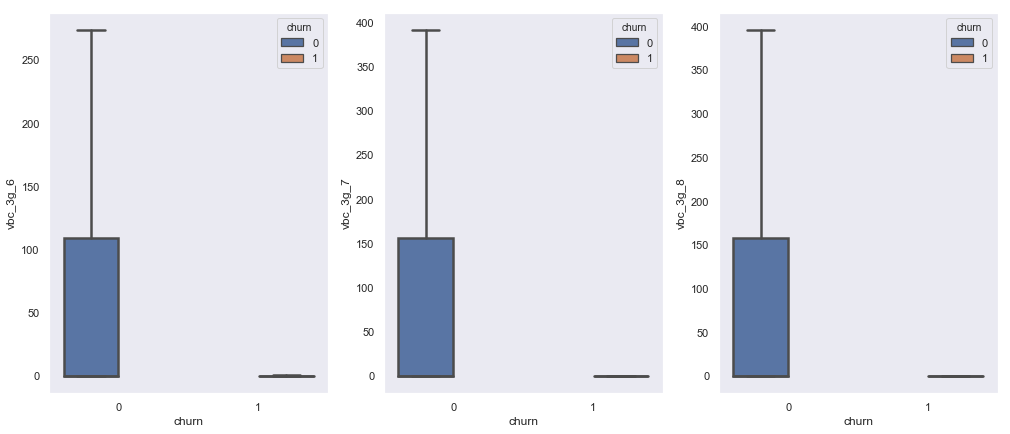

In [43]:
# let us rename month named vbc columns to 6,7,8,9 format
telecom_data.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'
                         ,'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

# let's check the volumne based cost for 3G
volumn_based_cost_3g = telecom_data.columns[telecom_data.columns.str.contains('vbc_3g')]

# analyze volume based cost
analyze_feature('vbc_3g')

We can clearly see that volume based cost for 3G is much lower for Churned customers as compared to Non-Churned Customers and also there is a drop in vbc in 8th month.

In [44]:
# Let us define new derived columns
# 3g volume based cost for good phase: vbc_3g_good_ph
telecom_data['vbc_3g_good_ph'] = (telecom_data['vbc_3g_6'] + telecom_data['vbc_3g_7'])/2


##### Sachet Subscription

In [45]:
# let's check sachet subscription for 2G/3G
sachet_2g_or_3g = telecom_data.columns[telecom_data.columns.str.contains('sachet_2g|sachet_3g',regex=True)]

print(telecom_data.loc[:,sachet_2g_or_3g].describe())

pd.DataFrame([telecom_data.loc[telecom_data.churn==0,sachet_2g_or_3g].mean()
              ,telecom_data.loc[telecom_data.churn==1,sachet_2g_or_3g].mean()],index={'Non Churned','Churned'})

        sachet_2g_6   sachet_2g_7   sachet_2g_8   sachet_3g_6   sachet_3g_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean       1.066064      1.214026      1.054865      0.209393      0.227492   
std        2.507197      2.736158      2.535940      0.985674      1.089929   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      0.000000      0.000000   
max       42.000000     48.000000     44.000000     29.000000     35.000000   

        sachet_3g_8  
count  30001.000000  
mean       0.202393  
std        1.100107  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       41.000000  


,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Non Churned,1.069303,1.243832,1.124383,0.206313,0.228048,0.214550
Churned,1.029496,0.877509,0.269971,0.244162,0.221221,0.065137


There is a steep drop in sachet services in 8th month for churned cutsomers as compared to non churned customers

In [46]:
# Let us define two new derived columns
# 2G sachet for good phase: sachet_2g_good_ph
# 3G sachet for good phase: sachet_3g_good_ph
telecom_data['sachet_2g_good_ph'] = (telecom_data.sachet_2g_6 + telecom_data.sachet_2g_7)/2
telecom_data['sachet_3g_good_ph'] = (telecom_data.sachet_3g_6 + telecom_data.sachet_3g_7)/2


Age on Network

In [47]:
# let's check the age on n/w for churned and non churned customers
print(telecom_data.loc[telecom_data.churn==1,'aon'].mean())
print(telecom_data.loc[telecom_data.churn==0,'aon'].mean())

860.9524784924212
1240.2281204644412


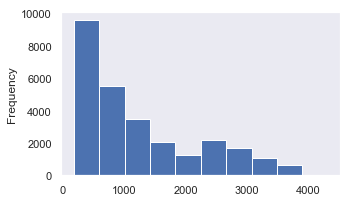

In [48]:
# let's check the age distribution for non churned customers
plt.figure(figsize=(5,3))
telecom_data.loc[telecom_data.churn==0,'aon'].plot.hist()

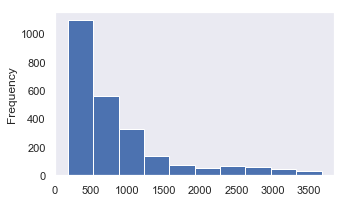

In [49]:
# let's check the age distribution for churned customers
plt.figure(figsize=(5,3))
telecom_data.loc[telecom_data.churn==1,'aon'].plot.hist()

#### Average revenue per user

Churn Stats (mean and standard deviation):
{6: 'arpu_6', 7: 'arpu_7', 8: 'arpu_8'}


<Figure size 1224x504 with 0 Axes>

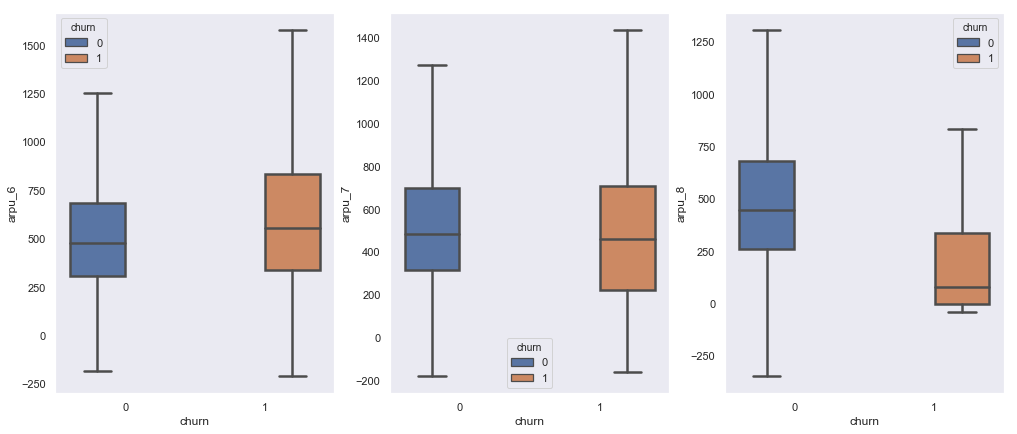

In [50]:
# extract columns for average revenue per user
arpu_cols = telecom_data.columns[telecom_data.columns.str.contains('arpu_')]

# analyze arpu
analyze_feature('arpu')
# Let us define new derived columns
# arpu for good phase: arpu_good_ph
telecom_data['arpu_good_ph'] = (telecom_data.arpu_6 + telecom_data.arpu_7)/2


##### Deriving columns for Outgoing minutes of Usage 

In [51]:
# let's define good phase derived variables for all og components:
telecom_data['spl_og_mou_good_ph'] = (telecom_data.spl_og_mou_6 + telecom_data.spl_og_mou_7)/2
telecom_data['isd_og_mou_good_ph'] = (telecom_data.isd_og_mou_6 + telecom_data.isd_og_mou_7)/2
telecom_data['roam_og_mou_good_ph'] = (telecom_data.roam_og_mou_6 + telecom_data.roam_og_mou_7)/2
telecom_data['std_og_t2m_mou_good_ph'] = (telecom_data.std_og_t2m_mou_6 + telecom_data.std_og_t2m_mou_7)/2
telecom_data['std_og_t2t_mou_good_ph'] = (telecom_data.std_og_t2t_mou_6 + telecom_data.std_og_t2t_mou_7)/2
telecom_data['std_og_t2f_mou_good_ph'] = (telecom_data.std_og_t2f_mou_6 + telecom_data.std_og_t2f_mou_7)/2

telecom_data['loc_og_t2m_mou_good_ph'] = (telecom_data.loc_og_t2m_mou_6 + telecom_data.loc_og_t2m_mou_7)/2
telecom_data['loc_og_t2t_mou_good_ph'] = (telecom_data.loc_og_t2t_mou_6 + telecom_data.loc_og_t2t_mou_7)/2
telecom_data['loc_og_t2f_mou_good_ph'] = (telecom_data.loc_og_t2f_mou_6 + telecom_data.loc_og_t2f_mou_7)/2
telecom_data['loc_og_t2c_mou_good_ph'] = (telecom_data.loc_og_t2c_mou_6 + telecom_data.loc_og_t2c_mou_7)/2

##### Let's check for incoming mou variables

In [52]:
# let's define good phase derive variables for all ic components:
telecom_data['spl_ic_mou_good_ph'] = (telecom_data.spl_ic_mou_6 + telecom_data.spl_ic_mou_7)/2
telecom_data['isd_ic_mou_good_ph'] = (telecom_data.isd_ic_mou_6 + telecom_data.isd_ic_mou_7)/2
telecom_data['roam_ic_mou_good_ph'] = (telecom_data.roam_ic_mou_6 + telecom_data.roam_ic_mou_7)/2
telecom_data['std_ic_t2m_mou_good_ph'] = (telecom_data.std_ic_t2m_mou_6 + telecom_data.std_ic_t2m_mou_7)/2
telecom_data['std_ic_t2t_mou_good_ph'] = (telecom_data.std_ic_t2t_mou_6 + telecom_data.std_ic_t2t_mou_7)/2
telecom_data['std_ic_t2f_mou_good_ph'] = (telecom_data.std_ic_t2f_mou_6 + telecom_data.std_ic_t2f_mou_7)/2
telecom_data['loc_ic_t2m_mou_good_ph'] = (telecom_data.loc_ic_t2m_mou_6 + telecom_data.loc_ic_t2m_mou_7)/2
telecom_data['loc_ic_t2t_mou_good_ph'] = (telecom_data.loc_ic_t2t_mou_6 + telecom_data.loc_ic_t2t_mou_7)/2
telecom_data['loc_ic_t2f_mou_good_ph'] = (telecom_data.loc_ic_t2f_mou_6 + telecom_data.loc_ic_t2f_mou_7)/2

##### Offnet Usage

Churn Stats (mean and standard deviation):
{6: 'offnet_mou_6', 7: 'offnet_mou_7', 8: 'offnet_mou_8'}


<Figure size 1224x504 with 0 Axes>

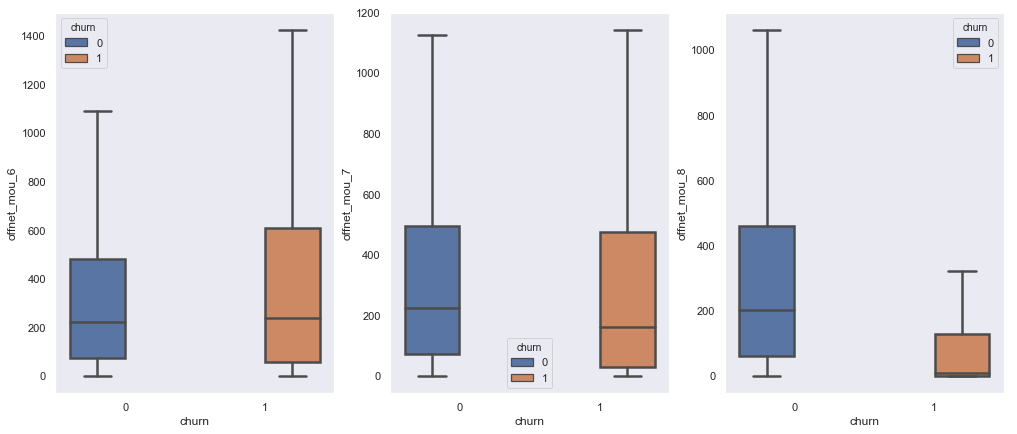

In [53]:
offnet_cols = telecom_data.columns[telecom_data.columns.str.contains('offnet',regex=True)]
# let's analyze for offnet mou values for churned and non churned customers
analyze_feature('offnet_mou')

# Let us define new derived column
# minutes of usage for good phase: onnet_mou_good_ph
telecom_data['offnet_mou_good_ph'] = (telecom_data.offnet_mou_6 + telecom_data.offnet_mou_7)/2

##### Minutes of usage related variables within same operator network

Churn Stats (mean and standard deviation):
{6: 'onnet_mou_6', 7: 'onnet_mou_7', 8: 'onnet_mou_8'}


<Figure size 1224x504 with 0 Axes>

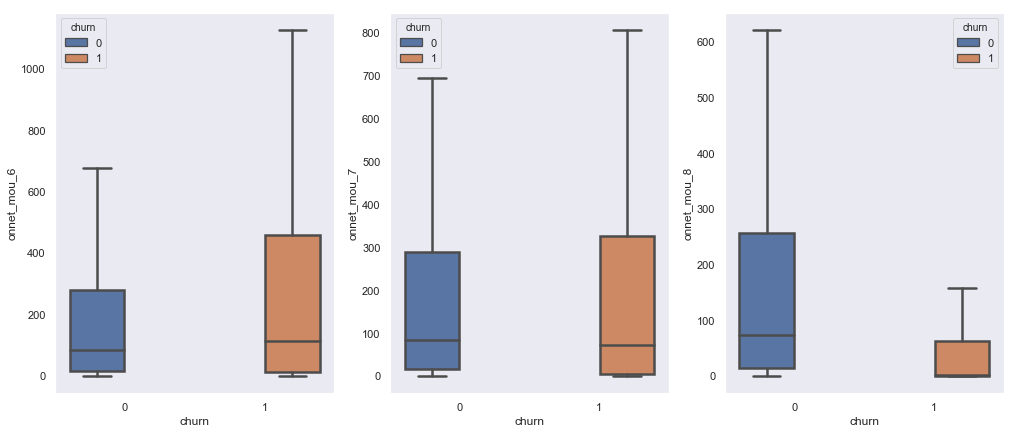

In [54]:
#let's extract the minutes of usage related columns
onnet_cols =  telecom_data.columns[telecom_data.columns.str.contains('^onnet.*mou',regex=True)]

# let's analyze for offnet mou values for churned and non churned customers
analyze_feature('onnet_mou')

# Let us define new derived column
# minutes of usage for good phase: onnet_mou_good_ph
telecom_data['onnet_mou_good_ph'] = (telecom_data.onnet_mou_6 + telecom_data.onnet_mou_7)/2

##### Analysing Other columns

In [55]:
# let's check summary stats for oc others and ic others mou
ls_others = telecom_data.columns[telecom_data.columns.str.contains('_others')]

print(telecom_data.loc[:,ls_others].describe())

# Let us define two new derived columns
# OG others for good phase: og_others_good_ph
# IC otherd for good phase: ic_others_good_ph
telecom_data['og_others_good_ph'] = (telecom_data.og_others_6 + telecom_data.og_others_7)/2
telecom_data['ic_others_good_ph'] = (telecom_data.ic_others_6 + telecom_data.ic_others_7)/2

        og_others_6   og_others_7   og_others_8   ic_others_6   ic_others_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean       0.661092      0.042905      0.057607      1.153449      1.500338   
std        4.107960      2.676794      3.315125     13.985934     15.997307   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.050000      0.000000   
max      609.810000    370.130000    394.930000   1344.140000   1495.940000   

        ic_others_8  
count  30001.000000  
mean       1.224455  
std       12.783238  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max     1209.860000  


##### Handling Days derived fields for good phase

In [56]:
# let's check summary stats for day of last recharge for calls 
ls_date = telecom_data.columns[telecom_data.columns.str.contains('day_of_')]

print(telecom_data.loc[:,ls_date].describe())
telecom_data['day_of_last_rech_good_ph'] = (telecom_data.day_of_last_rech_6 + telecom_data.day_of_last_rech_7)/2
telecom_data['day_of_last_rech_data_good_ph'] = (telecom_data.day_of_last_rech_data_6 + telecom_data.day_of_last_rech_data_7)/2

       day_of_last_rech_6  day_of_last_rech_7  day_of_last_rech_8  \
count        30001.000000        30001.000000        30001.000000   
mean            26.398320           27.180527           26.168928   
std              4.845796            4.837576            6.388573   
min              0.000000            0.000000            0.000000   
25%             25.000000           26.000000           25.000000   
50%             28.000000           29.000000           28.000000   
75%             30.000000           31.000000           30.000000   
max             30.000000           31.000000           31.000000   

       day_of_last_rech_data_6  day_of_last_rech_data_7  \
count             30001.000000             30001.000000   
mean                 11.266158                11.974034   
std                  11.795880                12.237130   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   7.

##### Handling Booleans fields 

In [57]:
#FB Users good phase 

ls_fb_pck = telecom_data.columns[telecom_data.columns.str.contains('fb_')]

print(telecom_data.loc[:,ls_fb_pck].describe())
telecom_data['fb_user_good_ph'] = telecom_data.fb_user_7

          fb_user_6     fb_user_7     fb_user_8
count  30001.000000  30001.000000  30001.000000
mean       0.958968      0.955501      0.945335
std        0.198367      0.206203      0.227329
min        0.000000      0.000000      0.000000
25%        1.000000      1.000000      1.000000
50%        1.000000      1.000000      1.000000
75%        1.000000      1.000000      1.000000
max        1.000000      1.000000      1.000000


In [58]:
#NIght pack good phase
ls_night_pck = telecom_data.columns[telecom_data.columns.str.contains('night_')]

print(telecom_data.loc[:,ls_night_pck].describe())

telecom_data['night_pck_user_good_ph'] = round((telecom_data.night_pck_user_6 + telecom_data.night_pck_user_7)/2)

       night_pck_user_6  night_pck_user_7  night_pck_user_8
count      30001.000000      30001.000000      30001.000000
mean           0.013600          0.107496          0.084097
std            0.115823          0.309749          0.277538
min            0.000000          0.000000          0.000000
25%            0.000000          0.000000          0.000000
50%            0.000000          0.000000          0.000000
75%            0.000000          0.000000          0.000000
max            1.000000          1.000000          1.000000


#### Dropping all 6 & 7TH month columns since we have good phase dervied columns

In [59]:
# let's extract all list of 6th and 7th Month (churned month) Columns
month_6_7_columns =  telecom_data.columns[telecom_data.columns.str.contains('.*_6|.*_7',regex=True)]

# drop all columns corresponding to the attributes of churn phase, since we have already derrived the good phase columns
telecom_data.drop(month_6_7_columns,axis=1,inplace=True)

In [60]:
telecom_data.shape

(30001, 105)

In [61]:
# Lets check non null values against each columns
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 105 entries, mobile_number to night_pck_user_good_ph
dtypes: float64(93), int64(12)
memory usage: 25.5 MB


In [62]:
telecom_data.drop('total_avg_rech_amt_good_ph', axis=1, inplace=True)
100*telecom_data.isnull().sum()/len(telecom_data.index)

mobile_number                    0.0
circle_id                        0.0
loc_og_t2o_mou                   0.0
std_og_t2o_mou                   0.0
loc_ic_t2o_mou                   0.0
arpu_8                           0.0
onnet_mou_8                      0.0
offnet_mou_8                     0.0
roam_ic_mou_8                    0.0
roam_og_mou_8                    0.0
loc_og_t2t_mou_8                 0.0
loc_og_t2m_mou_8                 0.0
loc_og_t2f_mou_8                 0.0
loc_og_t2c_mou_8                 0.0
loc_og_mou_8                     0.0
std_og_t2t_mou_8                 0.0
std_og_t2m_mou_8                 0.0
std_og_t2f_mou_8                 0.0
std_og_t2c_mou_8                 0.0
std_og_mou_8                     0.0
isd_og_mou_8                     0.0
spl_og_mou_8                     0.0
og_others_8                      0.0
total_og_mou_8                   0.0
loc_ic_t2t_mou_8                 0.0
loc_ic_t2m_mou_8                 0.0
loc_ic_t2f_mou_8                 0.0
l

# Step 5

## Outliers Treatment

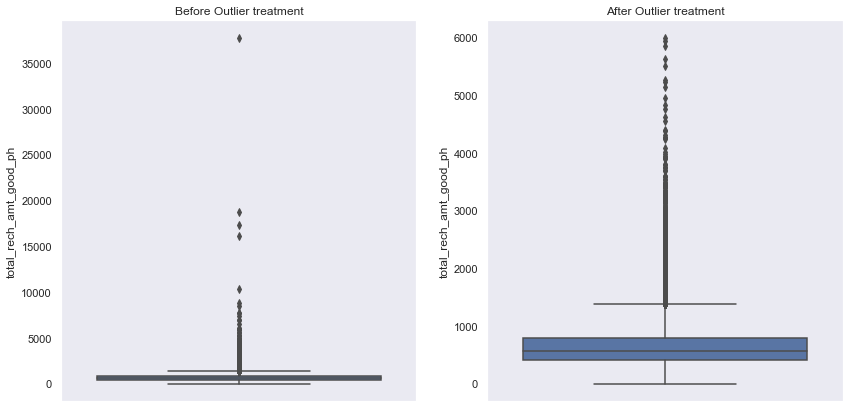

In [63]:
#Outliers in total_rech_amt_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['total_rech_amt_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['total_rech_amt_good_ph']>6000].index)
sns.boxplot(y=telecom_data['total_rech_amt_good_ph'])
plt.show()

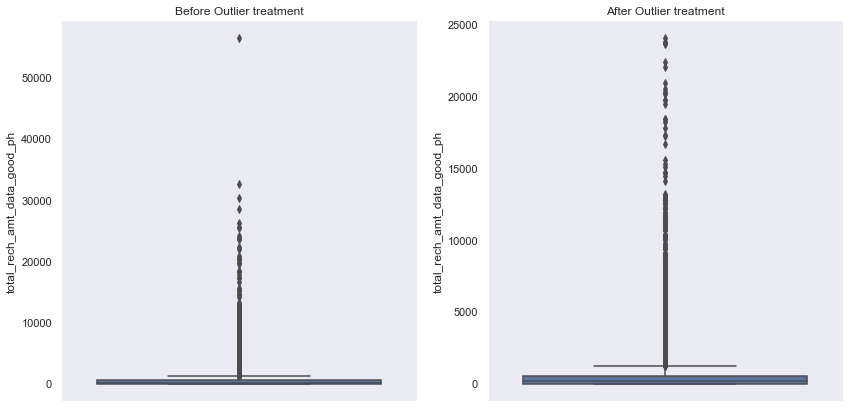

In [64]:
#Outliers in total_rech_amt_data_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['total_rech_amt_data_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['total_rech_amt_data_good_ph']>25000].index)
sns.boxplot(y=telecom_data['total_rech_amt_data_good_ph'])
plt.show()

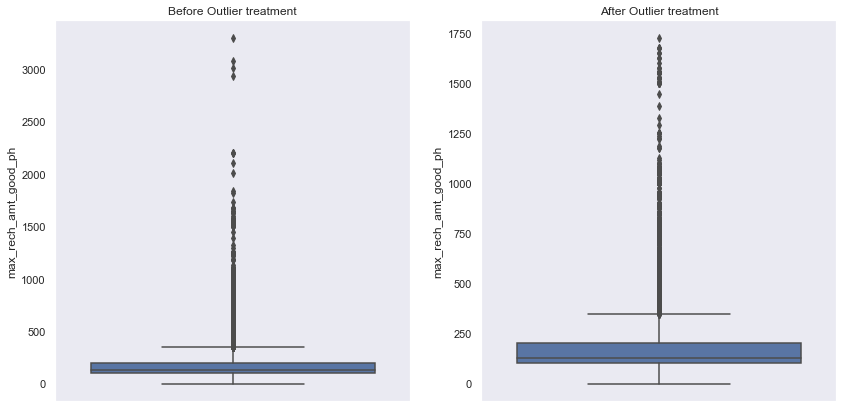

In [65]:
#Outliers in max_rech_amt_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['max_rech_amt_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['max_rech_amt_good_ph']>1800].index)
sns.boxplot(y=telecom_data['max_rech_amt_good_ph'])
plt.show()

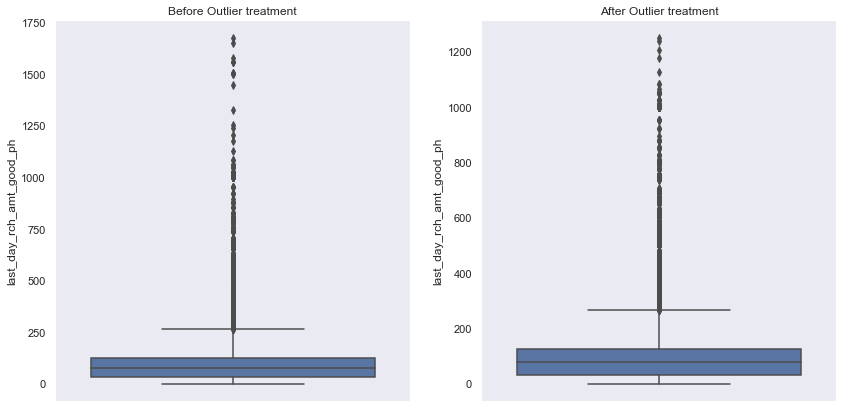

In [66]:
#Outliers in last_day_rch_amt_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['last_day_rch_amt_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['last_day_rch_amt_good_ph']>1250].index)
sns.boxplot(y=telecom_data['last_day_rch_amt_good_ph'])
plt.show()


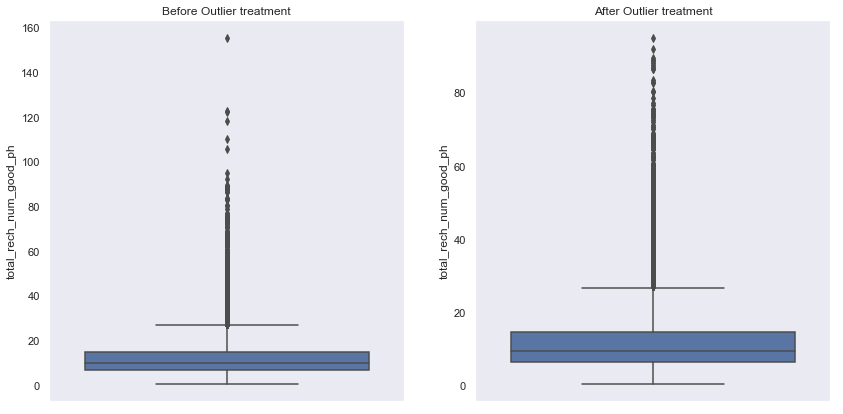

In [67]:
#Outliers in total_rech_num_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['total_rech_num_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['total_rech_num_good_ph']>100].index)
sns.boxplot(y=telecom_data['total_rech_num_good_ph'])
plt.show()

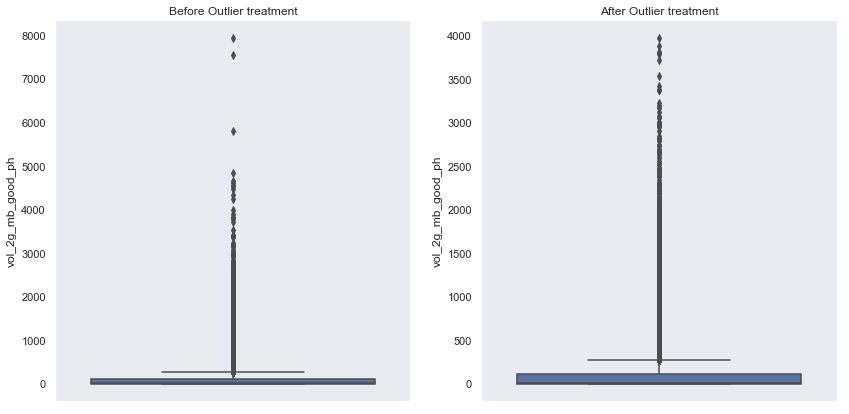

In [68]:
#Outliers in vol_2g_mb_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['vol_2g_mb_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['vol_2g_mb_good_ph']>4000].index)
sns.boxplot(y=telecom_data['vol_2g_mb_good_ph'])
plt.show()

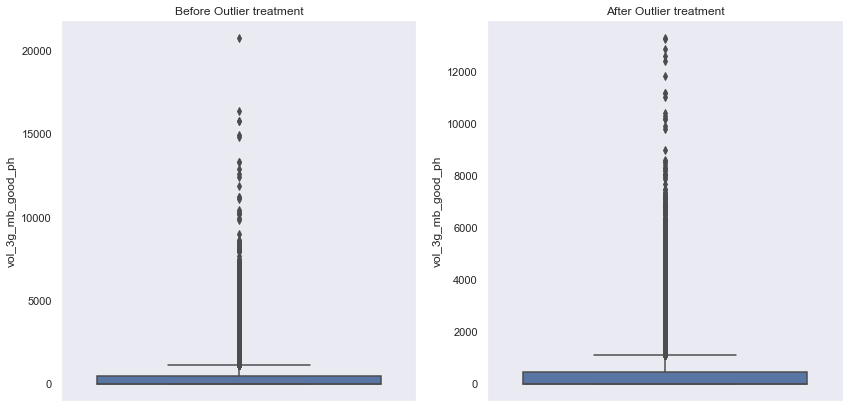

In [69]:
#Outliers in vol_3g_mb_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['vol_3g_mb_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['vol_3g_mb_good_ph']>14000].index)
sns.boxplot(y=telecom_data['vol_3g_mb_good_ph'])
plt.show()

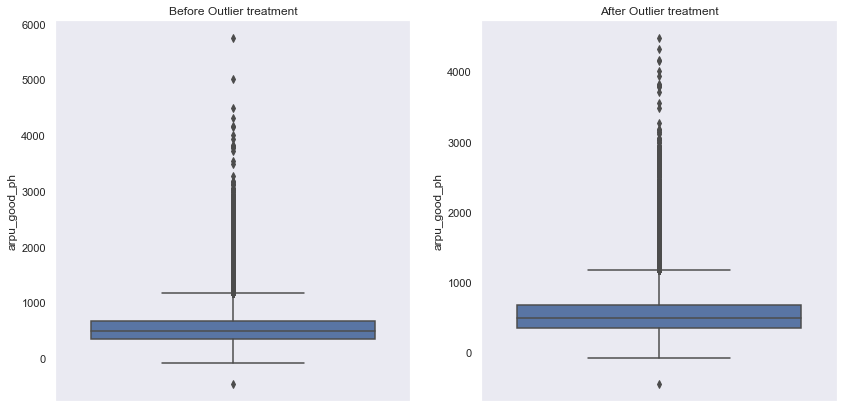

In [70]:
#Outliers in arpu_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['arpu_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['arpu_good_ph']>4600].index)
sns.boxplot(y=telecom_data['arpu_good_ph'])
plt.show()

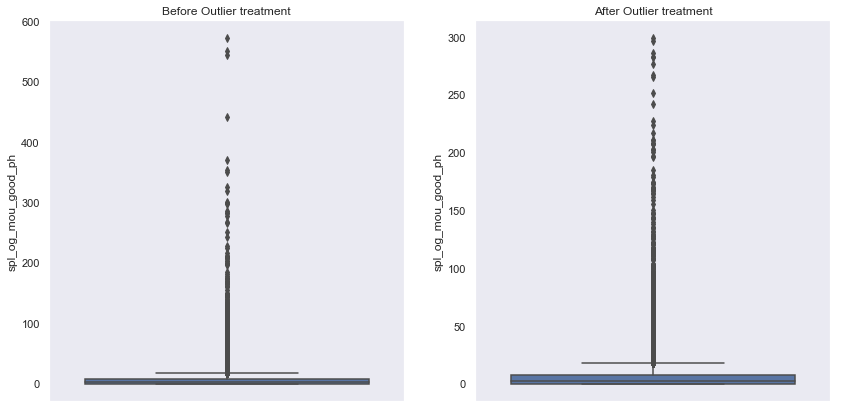

In [71]:
#Outliers in spl_og_mou_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['spl_og_mou_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['spl_og_mou_good_ph']>300].index)
sns.boxplot(y=telecom_data['spl_og_mou_good_ph'])
plt.show()

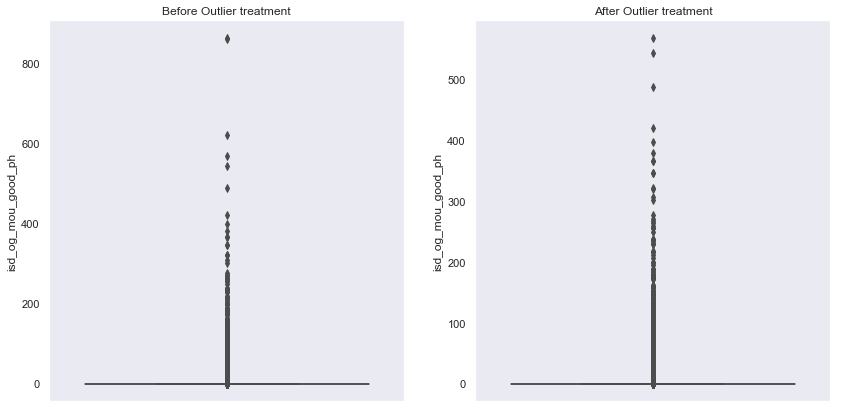

In [72]:
#Outliers in isd_og_mou_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['isd_og_mou_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['isd_og_mou_good_ph']>600].index)
sns.boxplot(y=telecom_data['isd_og_mou_good_ph'])
plt.show()

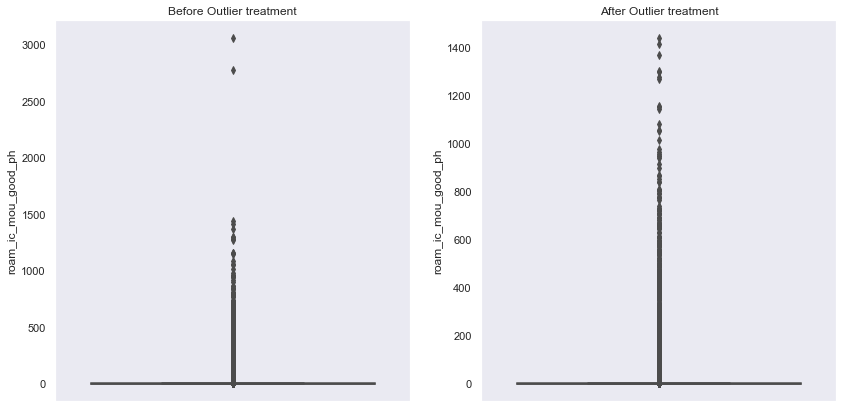

In [73]:
#Outliers in roam_ic_mou_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['roam_ic_mou_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['roam_ic_mou_good_ph']>1500].index)
sns.boxplot(y=telecom_data['roam_ic_mou_good_ph'])
plt.show()

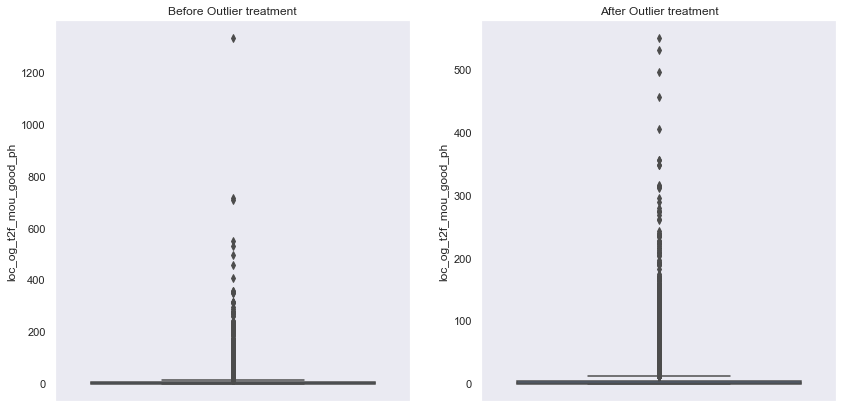

In [74]:
#Outliers in loc_og_t2f_mou_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['loc_og_t2f_mou_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['loc_og_t2f_mou_good_ph']>600].index)
sns.boxplot(y=telecom_data['loc_og_t2f_mou_good_ph'])
plt.show()

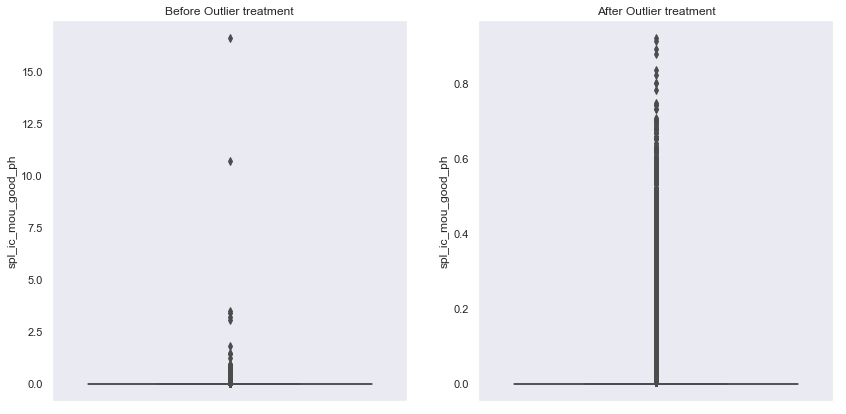

In [75]:
#Outliers in spl_ic_mou_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['spl_ic_mou_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['spl_ic_mou_good_ph']>1].index)
sns.boxplot(y=telecom_data['spl_ic_mou_good_ph'])
plt.show()

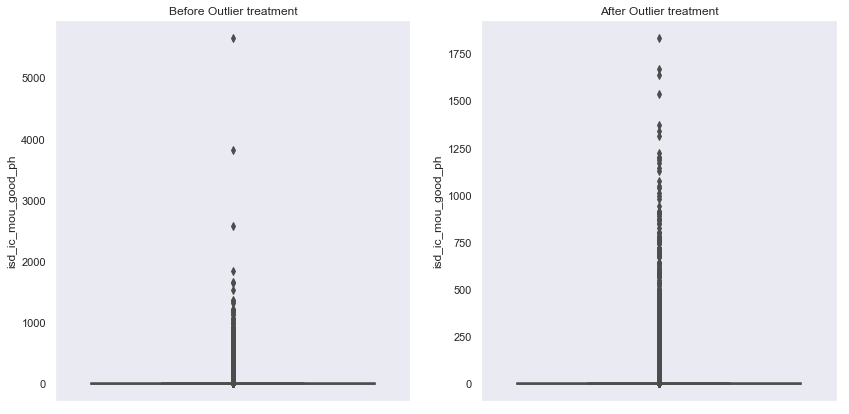

In [76]:
#Outliers in isd_ic_mou_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['isd_ic_mou_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['isd_ic_mou_good_ph']>2000].index)
sns.boxplot(y=telecom_data['isd_ic_mou_good_ph'])
plt.show()

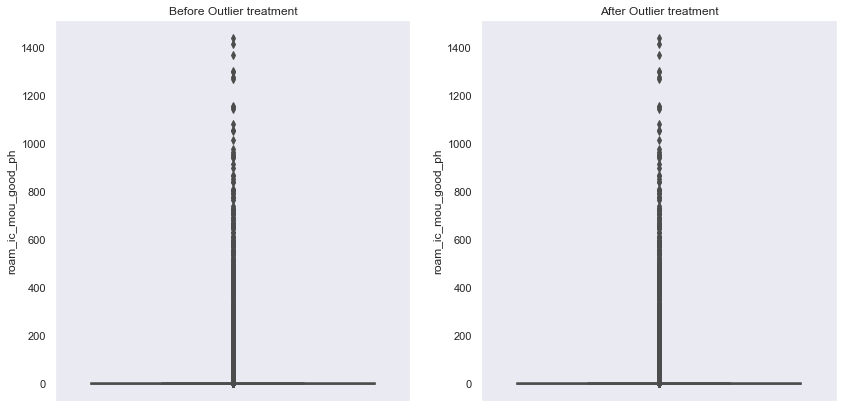

In [77]:
#Outliers in roam_ic_mou_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['roam_ic_mou_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['roam_ic_mou_good_ph']>1500].index)
sns.boxplot(y=telecom_data['roam_ic_mou_good_ph'])
plt.show()

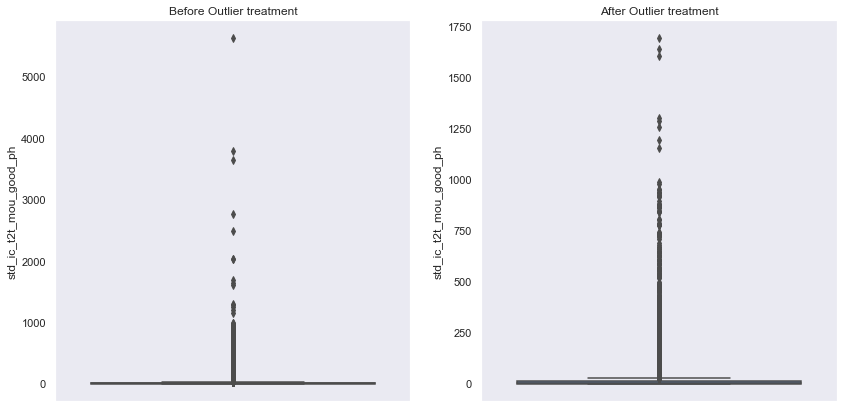

In [78]:
#Outliers in std_ic_t2t_mou_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['std_ic_t2t_mou_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['std_ic_t2t_mou_good_ph']>2000].index)
sns.boxplot(y=telecom_data['std_ic_t2t_mou_good_ph'])
plt.show()

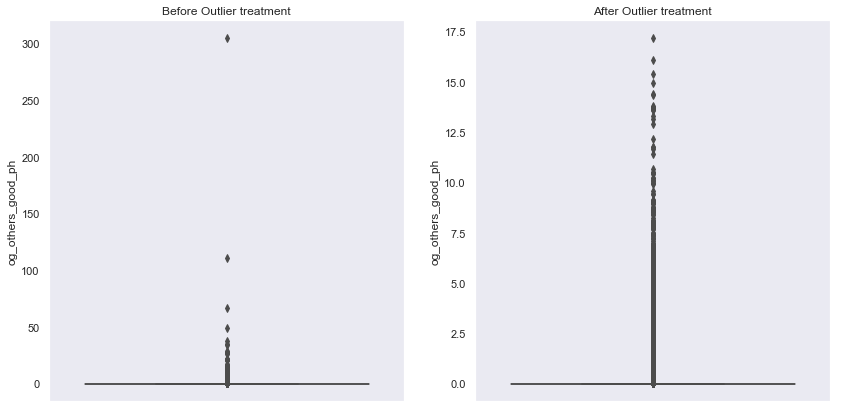

In [79]:
#Outliers in og_others_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['og_others_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['og_others_good_ph']>20].index)
sns.boxplot(y=telecom_data['og_others_good_ph'])
plt.show()

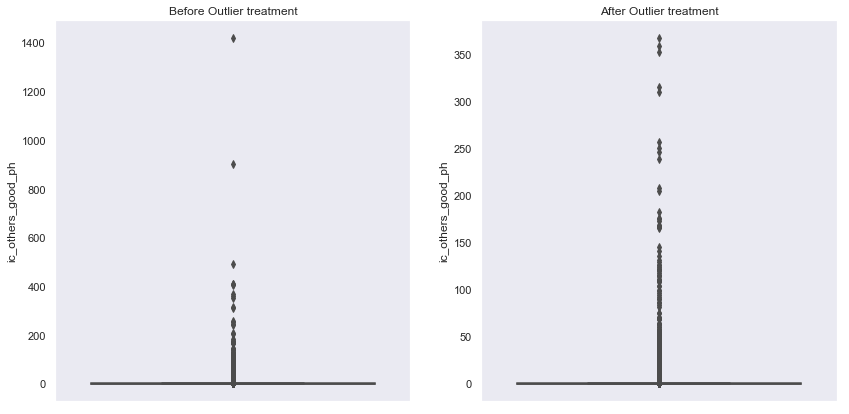

In [80]:
#Outliers in ic_others_good_ph
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Before Outlier treatment')
sns.boxplot(y=telecom_data['ic_others_good_ph'])
plt.subplot(1,2,2)
plt.title('After Outlier treatment')
telecom_data = telecom_data.drop(telecom_data[telecom_data['ic_others_good_ph']>400].index)
sns.boxplot(y=telecom_data['ic_others_good_ph'])
plt.show()

In [81]:
telecom_data.shape

(29871, 104)

In [82]:
telecom_data.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8',
       'roam_ic_mou_8', 'roam_og_mou_8',
       ...
       'loc_ic_t2t_mou_good_ph', 'loc_ic_t2f_mou_good_ph',
       'offnet_mou_good_ph', 'onnet_mou_good_ph', 'og_others_good_ph',
       'ic_others_good_ph', 'day_of_last_rech_good_ph',
       'day_of_last_rech_data_good_ph', 'fb_user_good_ph',
       'night_pck_user_good_ph'],
      dtype='object', length=104)

# Step 6

## Model Building

### In this section we will build multiple machine learning models to accurately predict customers who might churn in the action phase (8th Month)

In [83]:
# Putting feature variable to X
#Dropping Circle_id as everyone is from same id
X = telecom_data.drop(['churn','mobile_number', 'circle_id' ],axis=1)

# Putting response variable to y
y = telecom_data['churn']

### Add feature engineering

##### We will do some additional feature transformation to achieve better accuracy in our predictive model. We know from EDA above that a drop in action phase parameter as compared to good phase value is highly indicative of a likely churn, let's derive action phase column which is actually the difference between good phase feature value and action phase (8th month) feature value and discard the 8th month feature columns.

In [84]:
# extract good phase feature list and 8th month feature list
f_good_ph = X.loc[:,X.columns.str.contains('good_ph')]
f_good_ph.head()

,total_rech_amt_good_ph,total_rech_amt_data_good_ph,max_rech_amt_good_ph,last_day_rch_amt_good_ph,max_rech_data_good_ph,total_rech_num_good_ph,vol_2g_mb_good_ph,vol_3g_mb_good_ph,monthly_2g_good_ph,monthly_3g_good_ph,vbc_3g_good_ph,sachet_2g_good_ph,sachet_3g_good_ph,arpu_good_ph,spl_og_mou_good_ph,isd_og_mou_good_ph,roam_og_mou_good_ph,std_og_t2m_mou_good_ph,std_og_t2t_mou_good_ph,std_og_t2f_mou_good_ph,loc_og_t2m_mou_good_ph,loc_og_t2t_mou_good_ph,loc_og_t2f_mou_good_ph,loc_og_t2c_mou_good_ph,spl_ic_mou_good_ph,isd_ic_mou_good_ph,roam_ic_mou_good_ph,std_ic_t2m_mou_good_ph,std_ic_t2t_mou_good_ph,std_ic_t2f_mou_good_ph,loc_ic_t2m_mou_good_ph,loc_ic_t2t_mou_good_ph,loc_ic_t2f_mou_good_ph,offnet_mou_good_ph,onnet_mou_good_ph,og_others_good_ph,ic_others_good_ph,day_of_last_rech_good_ph,day_of_last_rech_data_good_ph,fb_user_good_ph,night_pck_user_good_ph
0,307.0,252.0,252.0,252.0,252.0,3.5,15.725,117.165,0.0,1.0,50.600,0.0,0.0,206.1005,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.0,0.000,18.5,18.5,1.0,0.0
7,1185.0,0.0,1185.0,0.0,0.0,5.0,0.000,0.000,0.0,0.0,19.060,0.0,0.0,1209.5150,2.25,0.090,18.165,40.825,13.795,13.37,378.005,41.385,58.635,0.0,0.105,8.295,24.86,109.215,24.360,43.215,219.525,45.200,126.810,510.295,56.26,0.0,15.465,26.0,0.0,1.0,0.0
8,519.0,177.0,122.0,25.0,77.0,20.0,178.000,375.475,0.5,0.0,516.405,0.5,0.0,435.4720,0.00,0.000,0.000,11.865,124.995,0.00,75.770,257.360,0.000,0.0,0.000,0.000,0.00,13.255,0.290,0.000,35.780,16.840,0.000,87.645,382.36,0.0,0.000,28.0,15.5,1.0,0.0
21,640.0,0.0,50.0,25.0,0.0,24.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,556.1030,0.00,0.000,0.000,737.050,111.935,0.00,89.870,5.320,0.375,0.0,0.000,0.000,0.00,52.960,10.020,0.000,96.430,6.335,3.725,827.305,117.26,0.0,0.000,30.5,0.0,1.0,0.0
23,227.0,356.0,89.5,89.5,89.5,4.0,0.240,299.545,0.0,1.0,25.930,0.0,0.0,134.1235,0.05,0.005,0.000,4.355,0.000,0.00,82.975,49.810,0.000,0.0,0.000,14.115,0.00,8.660,0.255,0.000,104.635,40.875,0.000,87.385,49.81,0.0,2.675,12.5,3.5,1.0,0.0


In [85]:
# define function to calculate difference between 8th month feature and good phase feature
def FindDiff(x,y):      
    diff = 0.00
    if np.isnan(x) and np.isnan(y):
        diff = np.NAN
    elif np.isnan(y) and ~np.isnan(x):
        diff = x
    elif ~np.isnan(y)and np.isnan(x):
        diff = -y
    else:
        diff = x-y
    return(diff)

In [86]:
# create a feature data frame copy from original features
X_diff = X.copy()

In [87]:
# extract features without any good phase or 8th month indicator.
features_to_explore = set(map(lambda x: x.replace("_good_ph", ""), f_good_ph))
features_to_explore

{'arpu',
 'day_of_last_rech',
 'day_of_last_rech_data',
 'fb_user',
 'ic_others',
 'isd_ic_mou',
 'isd_og_mou',
 'last_day_rch_amt',
 'loc_ic_t2f_mou',
 'loc_ic_t2m_mou',
 'loc_ic_t2t_mou',
 'loc_og_t2c_mou',
 'loc_og_t2f_mou',
 'loc_og_t2m_mou',
 'loc_og_t2t_mou',
 'max_rech_amt',
 'max_rech_data',
 'monthly_2g',
 'monthly_3g',
 'night_pck_user',
 'offnet_mou',
 'og_others',
 'onnet_mou',
 'roam_ic_mou',
 'roam_og_mou',
 'sachet_2g',
 'sachet_3g',
 'spl_ic_mou',
 'spl_og_mou',
 'std_ic_t2f_mou',
 'std_ic_t2m_mou',
 'std_ic_t2t_mou',
 'std_og_t2f_mou',
 'std_og_t2m_mou',
 'std_og_t2t_mou',
 'total_rech_amt',
 'total_rech_amt_data',
 'total_rech_num',
 'vbc_3g',
 'vol_2g_mb',
 'vol_3g_mb'}

In [88]:
# create new derived columns for action phase.
for feat in features_to_explore:
    X_diff[feat+'_act_ph']= np.vectorize(FindDiff)(X_diff[feat+'_8'], X_diff[feat+'_good_ph'])
    

In [89]:
#handling Boolean variables & days separtely
X_diff['day_of_last_rech_act_ph'] = X_diff.apply(lambda x: x.day_of_last_rech_good_ph if x.day_of_last_rech_good_ph > x.day_of_last_rech_8 else x.day_of_last_rech_8, axis=1)
X_diff['day_of_last_rech_data_act_ph'] = X_diff.apply(lambda x: x.day_of_last_rech_data_good_ph if x.day_of_last_rech_data_good_ph > x.day_of_last_rech_data_8 else x.day_of_last_rech_data_8 , axis=1)
X_diff['night_pck_user_act_ph'] = X_diff.apply(lambda x: 0 if x.night_pck_user_good_ph > x.night_pck_user_8 else 1, axis=1)
X_diff['fb_user_act_ph'] = X_diff.apply(lambda x: 0 if x.fb_user_good_ph > x.fb_user_8 else 1, axis=1)


In [90]:
f_8 = X.loc[:,X.columns.str.contains('_8')]
# drop 8th month columns as we have already derived action phase columns.
X_diff.drop(f_8,axis=1,inplace=True)

In [91]:
print(X_diff.shape)
X_diff.head()

(29871, 87)


,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,aon,vbc_3g_9,total_rech_amt_good_ph,total_rech_amt_data_good_ph,max_rech_amt_good_ph,last_day_rch_amt_good_ph,max_rech_data_good_ph,total_rech_num_good_ph,vol_2g_mb_good_ph,vol_3g_mb_good_ph,monthly_2g_good_ph,monthly_3g_good_ph,vbc_3g_good_ph,sachet_2g_good_ph,sachet_3g_good_ph,arpu_good_ph,spl_og_mou_good_ph,isd_og_mou_good_ph,roam_og_mou_good_ph,std_og_t2m_mou_good_ph,std_og_t2t_mou_good_ph,std_og_t2f_mou_good_ph,loc_og_t2m_mou_good_ph,loc_og_t2t_mou_good_ph,loc_og_t2f_mou_good_ph,loc_og_t2c_mou_good_ph,spl_ic_mou_good_ph,isd_ic_mou_good_ph,roam_ic_mou_good_ph,std_ic_t2m_mou_good_ph,std_ic_t2t_mou_good_ph,std_ic_t2f_mou_good_ph,loc_ic_t2m_mou_good_ph,loc_ic_t2t_mou_good_ph,loc_ic_t2f_mou_good_ph,offnet_mou_good_ph,onnet_mou_good_ph,og_others_good_ph,ic_others_good_ph,day_of_last_rech_good_ph,day_of_last_rech_data_good_ph,fb_user_good_ph,night_pck_user_good_ph,onnet_mou_act_ph,ic_others_act_ph,std_ic_t2m_mou_act_ph,std_ic_t2f_mou_act_ph,vol_2g_mb_act_ph,day_of_last_rech_act_ph,roam_ic_mou_act_ph,loc_og_t2t_mou_act_ph,max_rech_data_act_ph,spl_og_mou_act_ph,loc_og_t2f_mou_act_ph,std_og_t2t_mou_act_ph,isd_ic_mou_act_ph,night_pck_user_act_ph,std_og_t2f_mou_act_ph,monthly_3g_act_ph,total_rech_amt_act_ph,total_rech_num_act_ph,fb_user_act_ph,vol_3g_mb_act_ph,spl_ic_mou_act_ph,total_rech_amt_data_act_ph,og_others_act_ph,day_of_last_rech_data_act_ph,monthly_2g_act_ph,std_ic_t2t_mou_act_ph,std_og_t2m_mou_act_ph,arpu_act_ph,loc_og_t2m_mou_act_ph,roam_og_mou_act_ph,loc_ic_t2m_mou_act_ph,last_day_rch_amt_act_ph,isd_og_mou_act_ph,max_rech_amt_act_ph,sachet_3g_act_ph,loc_ic_t2t_mou_act_ph,offnet_mou_act_ph,loc_og_t2c_mou_act_ph,sachet_2g_act_ph,loc_ic_t2f_mou_act_ph,vbc_3g_act_ph
0,0.0,0.0,0.0,968,3.58,307.0,252.0,252.0,252.0,252.0,3.5,15.725,117.165,0.0,1.0,50.600,0.0,0.0,206.1005,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.0,0.000,18.5,18.5,1.0,0.0,0.00,0.000,0.000,0.000,-9.975,18.5,0.00,0.000,0.0,0.00,0.000,0.000,0.000,1,0.00,0.0,-55.0,-1.5,1,-7.555,0.000,0.0,0.0,18.5,0.0,0.000,0.000,7.7025,0.000,0.000,4.130,0.0,0.000,0.0,0.0,0.160,0.000,0.00,0.0,1.150,-20.200
7,0.0,0.0,0.0,802,0.00,1185.0,0.0,1185.0,0.0,0.0,5.0,0.000,0.000,0.0,0.0,19.060,0.0,0.0,1209.5150,2.25,0.090,18.165,40.825,13.795,13.37,378.005,41.385,58.635,0.0,0.105,8.295,24.86,109.215,24.360,43.215,219.525,45.200,126.810,510.295,56.26,0.0,15.465,26.0,0.0,1.0,0.0,-3.97,-0.325,32.115,-21.005,0.000,26.0,6.78,-1.105,0.0,4.25,-5.405,-1.785,23.295,1,3.31,0.0,2453.0,2.0,1,0.000,-0.105,0.0,0.0,0.0,0.0,6.030,8.315,1961.9650,-215.725,19.895,-98.335,779.0,9.920,395.0,0.0,-17.890,-184.385,0.00,0.0,-87.280,38.680
8,0.0,0.0,0.0,315,0.00,519.0,177.0,122.0,25.0,77.0,20.0,178.000,375.475,0.5,0.0,516.405,0.5,0.0,435.4720,0.00,0.000,0.000,11.865,124.995,0.00,75.770,257.360,0.000,0.0,0.000,0.000,0.00,13.255,0.290,0.000,35.780,16.840,0.000,87.645,382.36,0.0,0.000,28.0,15.5,1.0,0.0,-347.28,0.000,-12.605,0.000,-177.970,30.0,0.00,-244.870,-54.0,10.23,0.000,-102.415,0.000,1,0.00,0.0,-399.0,-6.0,1,-363.535,0.000,30.0,0.0,23.0,-0.5,-0.190,63.825,-298.1100,-25.230,0.000,-20.300,-15.0,0.000,-92.0,0.0,-16.530,48.835,7.15,2.5,0.000,-495.375
21,0.0,0.0,0.0,720,0.00,640.0,0.0,50.0,25.0,0.0,24.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,556.1030,0.00,0.000,0.000,737.050,111.935,0.00,89.870,5.320,0.375,0.0,0.000,0.000,0.00,52.960,10.020,0.000,96.430,6.335,3.725,827.305,117.26,0.0,0.000,30.5,0.0,1.0,0.0,-32.12,0.000,48.780,0.000,0.000,31.0,0.00,18.020,0.0,0.00,1.205,-50.145,0.000,1,0.00,0.0,78.0,3.0,1,0.000,0.000,0.0,0.0,0.0,0.0,-9.840,139.940,81.6570,14.940,0.000,32.730,25.0,0.000,0.0,0.0,13.205,156.085,0.00,0.0,6.665,0.000
23,0.0,0.0,0.0,604,0.00,227.0,356.0,89.5,89.5,89.5,4.0,0.240,299.545,0.0,1.0,25.930,0.0,0.0,134.1235,0.05,0.005,0.000,4.355,0.000,0.00,82.975,49.810,0.000,0.0,0.000,14.115,0.00,8.660,0.255,0.000,104.635,40.875,0.000,87.385,49.81,0.0,2.675,12.5,3.5,1.0,0.0,-16.23,10.385,35.250,0

#### Feature standardisation
##### Let's do a feature standardisation

In [92]:
# extract columns
cols = X_diff.columns
# apply standard scalar
scaler = StandardScaler()
# produce scaled features
X_scaled = scaler.fit_transform(X_diff)

# convert to data frame
X_scaled = pd.DataFrame(X_diff, columns=cols)

In [93]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, train_size=0.7,test_size=0.3,random_state=100)

Let's define a function to print out evaluation metrics, as we have customer churn as positive class (1) we would try to maximize sensitivity at the same time trying to keep auc_score at a good level.

In [94]:
# define function to calculate and print model metrics.
def printMetrics(y_test,y_pred):
    cp = confusion_matrix(y_test,y_pred)
    sensitivity = cp[1,1]/(cp[1,0]+cp[1,1])
    specificity =  cp[0,0]/(cp[0,1]+cp[0,0])
    precision = cp[1,1]/(cp[0,1]+cp[1,1])
    print('Confusion Matrix: \n',cp)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ",specificity)
    print("AUC Score: ", roc_auc_score(y_test,y_pred)) 
    print("Precision: ",precision)
    print("f1 Score: ",f1_score(y_test,y_pred))

0    27446
1     2425
Name: churn, dtype: int64

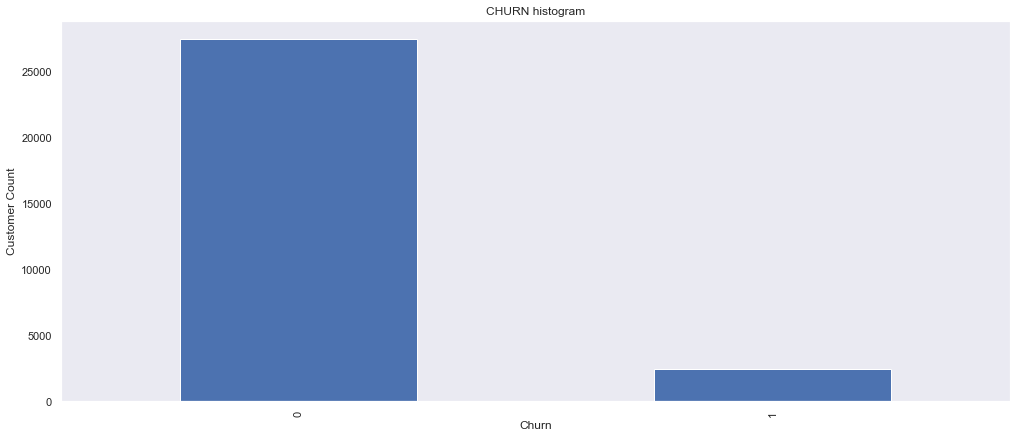

In [95]:
pd.value_counts(telecom_data['churn']).plot.bar()
plt.title('CHURN histogram')
plt.xlabel('Churn')
plt.ylabel('Customer Count')
telecom_data['churn'].value_counts()

We do see from above that the sesitivity and auc score is pretty low, this is because the data imbalanced with only 8.4% values for churn. **We will do imbalanced class handling to rectify this**.

#### Imbalanced class handling

In this section we will try to reduce class imbalance by trying out two techniques:

* **SMOTE resampling**: by generating synthetic samples for the minority class.
* **Majority Class Undersampling**: by deliberately undersampling the majority class.

#### SMOTE resampling

In [96]:
# use SMOTE sampler from imblearn library

smote = SMOTE()

In [97]:
# SMOTE sampling the training data
X_sm, y_sm = smote.fit_sample(X_train, y_train)

#### Majority Class Undersampling

We will create our own funtion for majority class undersampling. This function will randomly sample the majority class equal to the number of minority class samples from training data.

In [98]:
# function to undersample majority class
def MajorityClassUnderSampler(X_train,y_train):
    # create training data frame
    df_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)],axis=1)
    
    # select the minority class (in our case churn)
    df_train_minority_class  = df_train.loc[df_train.churn == 1,:]
    
    # create data frame with majority class samples same as minority class
    df_train_majority_undersampled = pd.concat([df_train_minority_class,df_train.loc[df_train.churn == 0,:].sample(df_train_minority_class.shape[0])])

    return df_train_majority_undersampled

In [99]:
# create majority class undersampled data frame from training data
df_train_mju = MajorityClassUnderSampler(X_train,y_train)

# extract features and labels
X_train_mju = df_train_mju.drop('churn',axis=1)
y_train_mju = df_train_mju.churn

In [100]:
#Use Logistic regression
lsr = LogisticRegression()
lsr.fit(X_sm,y_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [101]:
y_pred = lsr.predict(X_test)
printMetrics(y_test,y_pred)

Confusion Matrix: 
 [[6692 1541]
 [ 134  595]]
Sensitivity:  0.8161865569272977
Specificity:  0.8128264302198469
AUC Score:  0.8145064935735723
Precision:  0.2785580524344569
f1 Score:  0.41535776614310643


Let's generate model with majority class undersampling, as our function is doing random sampling of majority class, let's take the average of 10 runs to find the model metrics.

In [102]:
sensitivity_avg = 0
specificity_avg = 0
auc_score_avg = 0
precision_avg = 0

for i in range(0,10):
    #rus = RandomUnderSampler()
    #X_rs, y_rs = rus.fit_sample(X_train, y_train)
    df_train_mju = MajorityClassUnderSampler(X_train,y_train)
    # extract features and labels
    X_train_mju = df_train_mju.drop('churn',axis=1)
    y_train_mju = df_train_mju.churn
    lsr = LogisticRegression()
    lsr.fit(X_train_mju,y_train_mju)
    #lsr.fit(X_rs,y_rs)
    y_pred = lsr.predict(X_test)
    cp = confusion_matrix(y_test,y_pred)
    sensitivity = cp[1,1]/(cp[1,0]+cp[1,1])
    specificity =  cp[0,0]/(cp[0,1]+cp[0,0])
    precision = cp[1,1]/(cp[0,1]+cp[1,1])
    auc_score = roc_auc_score(y_test,y_pred)
    sensitivity_avg = sensitivity_avg + sensitivity
    specificity_avg = specificity_avg+ specificity
    auc_score_avg = auc_score_avg + auc_score
    precision_avg = precision_avg + precision 

In [103]:
print('Sensitivity: ',sensitivity_avg/10)
print('Specificity: ',specificity_avg/10)
print('AUC Score: ',auc_score_avg/10)
print('Precision: ',precision_avg/10)  

Sensitivity:  0.8179698216735252
Specificity:  0.8092554354427305
AUC Score:  0.8136126285581279
Precision:  0.27528672734878623


### Dimenesionality Reduction with PCA

As the number of features are quite high, let's try dimensionality reduction with PCA and try model creation on reduced feature set.

In [104]:
#Use PCA
pca = PCA(svd_solver='randomized', random_state=101)

In [105]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=101,
    svd_solver='randomized', tol=0.0, whiten=False)

In [106]:
# let's check the features with top PCA components
colnames = list(X_scaled.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

,PC1,PC2,Feature
0,-9.786521e-17,-2.218351e-17,loc_og_t2o_mou
1,-0.000000e+00,-5.551115e-17,std_og_t2o_mou
2,2.775558e-17,1.110223e-16,loc_ic_t2o_mou
3,2.672440e-02,-1.083787e-01,aon
4,-3.505259e-04,5.255878e-03,vbc_3g_9


### Scree Plot

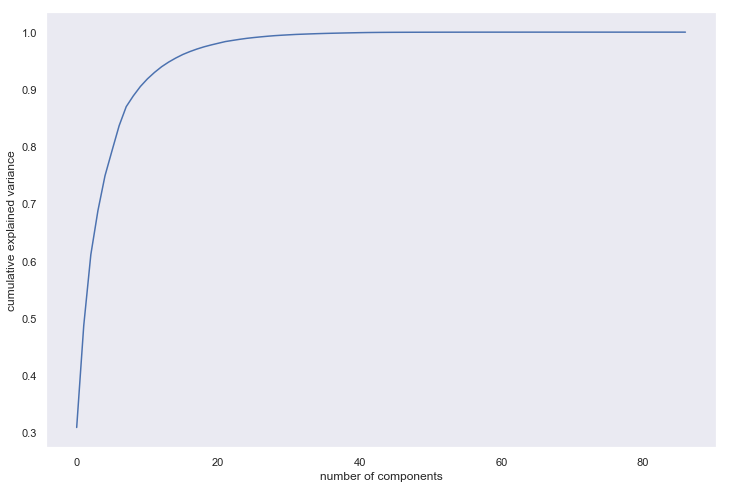

In [107]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

### We see from graph above that around around 40 features capture 95% variance, let's reduce our feature set to 40

In [108]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets

pca_final = IncrementalPCA(n_components=40)

In [109]:
X_train_pca = pca_final.fit_transform(X_train_mju)
X_train_pca.shape

(3392, 40)

In [110]:
X_test_pca = pca_final.transform(X_test)
X_test_pca.shape

(8962, 40)

In [111]:
n_pcs= pca_final.components_.shape[0]
most_important = [np.abs(pca_final.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = X_train.columns

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
print('PCA Selected columns: ', most_important_names)

PCA Selected columns:  ['total_rech_amt_data_good_ph', 'aon', 'aon', 'vol_3g_mb_good_ph', 'onnet_mou_good_ph', 'vol_3g_mb_act_ph', 'total_rech_amt_act_ph', 'total_rech_amt_good_ph', 'vol_3g_mb_act_ph', 'onnet_mou_act_ph', 'vol_2g_mb_good_ph', 'vbc_3g_good_ph', 'vbc_3g_good_ph', 'loc_og_t2t_mou_good_ph', 'loc_og_t2t_mou_good_ph', 'max_rech_amt_act_ph', 'vbc_3g_act_ph', 'loc_ic_t2m_mou_good_ph', 'roam_og_mou_good_ph', 'loc_og_t2t_mou_act_ph', 'vol_2g_mb_act_ph', 'loc_og_t2m_mou_act_ph', 'loc_ic_t2t_mou_good_ph', 'arpu_act_ph', 'last_day_rch_amt_act_ph', 'std_ic_t2m_mou_act_ph', 'max_rech_amt_act_ph', 'std_ic_t2m_mou_good_ph', 'roam_ic_mou_act_ph', 'max_rech_data_act_ph', 'roam_og_mou_act_ph', 'std_ic_t2m_mou_act_ph', 'loc_ic_t2t_mou_act_ph', 'std_ic_t2t_mou_good_ph', 'isd_ic_mou_good_ph', 'last_day_rch_amt_good_ph', 'arpu_good_ph', 'roam_ic_mou_good_ph', 'roam_ic_mou_good_ph', 'max_rech_data_act_ph']


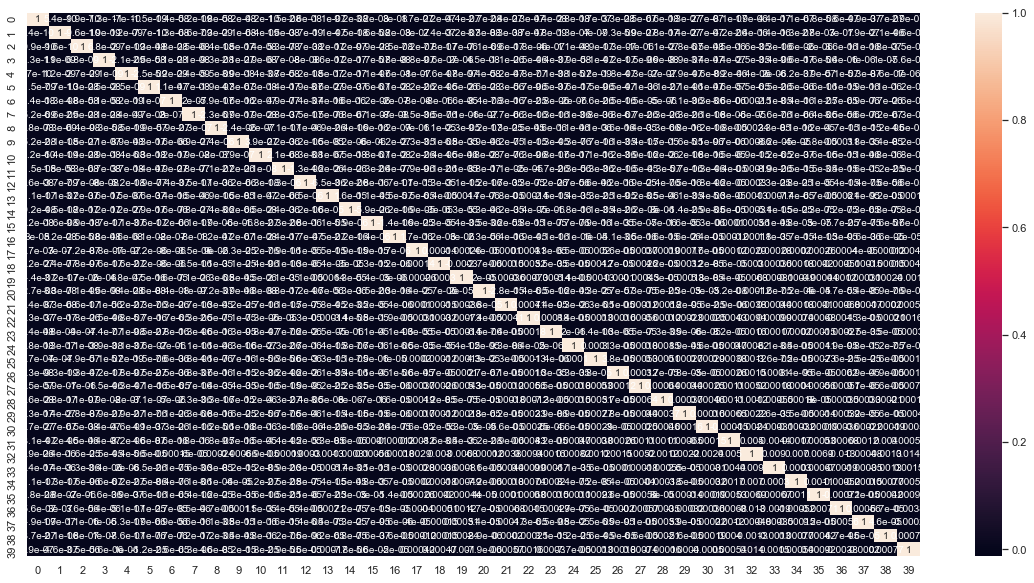

In [112]:
#creating correlation matrix for the principal components
corrmap = np.corrcoef(X_train_pca.transpose())

#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmap,annot = True)

# Step 7
## Model:1  Logistic Regression with PCA

In [113]:
# let's start by building as basic logistic regression model

lr_pca = LogisticRegression()
model_pca = lr_pca.fit(X_train_pca,y_train_mju)

In [114]:
y_pred = lr_pca.predict(X_test_pca)

In [115]:
printMetrics(y_test,y_pred)

Confusion Matrix: 
 [[6296 1937]
 [ 111  618]]
Sensitivity:  0.8477366255144033
Specificity:  0.7647273168954208
AUC Score:  0.8062319712049121
Precision:  0.24187866927592955
f1 Score:  0.37637028014616325


#### Adjusting probability threshold cutoff for logistic regression

We will now try to select the optimum probability threshold for our model

In [116]:
# check the predicted probabilities
y_pred_prob = lr_pca.predict_proba(X_test_pca)

In [117]:
# create predicted probability data frame
y_pred_prob_df = pd.DataFrame(y_pred_prob)
y_pred_prob_df = y_pred_prob_df.iloc[:,[1]]

y_test_df = pd.DataFrame(y_test)
y_test_df['ID'] = y_test_df.index

y_pred_prob_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_prob_df
y_pred_final = pd.concat([y_test_df,y_pred_prob_df],axis=1)

In [118]:
# renaming column
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
y_pred_final.head()

,churn,ID,Churn_Prob
0,0,54611,0.930195
1,0,95807,0.025467
2,0,94783,0.086141
3,0,17696,0.555523
4,0,26139,0.014299


In [119]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['ID','churn','Churn_Prob'], axis=1)
y_pred_final.head()

,ID,churn,Churn_Prob
0,54611,0,0.930195
1,95807,0,0.025467
2,94783,0,0.086141
3,17696,0,0.555523
4,26139,0,0.014299


In [120]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,ID,churn,Churn_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,54611,0,0.930195,1,1,1,1,1,1,1,1,1,1
1,95807,0,0.025467,1,0,0,0,0,0,0,0,0,0
2,94783,0,0.086141,1,0,0,0,0,0,0,0,0,0
3,17696,0,0.555523,1,1,1,1,1,1,0,0,0,0
4,26139,0,0.014299,1,0,0,0,0,0,0,0,0,0


In [121]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','speci','sensi','preci'])
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    preci = cm1[1,1]/(cm1[0,1]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,speci,sensi,preci]
print(cutoff_df)

     prob  accuracy     speci     sensi     preci
0.0   0.0  0.081343  0.000000  1.000000  0.081343
0.1   0.1  0.345012  0.289445  0.972565  0.108096
0.2   0.2  0.479692  0.438115  0.949246  0.130124
0.3   0.3  0.590270  0.560913  0.921811  0.156753
0.4   0.4  0.688239  0.670837  0.884774  0.192250
0.5   0.5  0.771480  0.764727  0.847737  0.241879
0.6   0.6  0.837871  0.841249  0.799726  0.308466
0.7   0.7  0.883731  0.899672  0.703704  0.383122
0.8   0.8  0.909618  0.940240  0.563786  0.455150
0.9   0.9  0.920107  0.975950  0.289438  0.515892


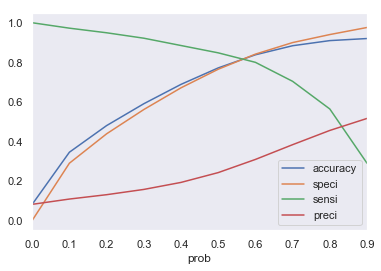

In [122]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','speci','sensi','preci'])

In [123]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.51 else 0)

In [124]:
#Let's check the overall accuracy.
printMetrics(y_pred_final.churn, y_pred_final.final_predicted)
lr_confusion_matrix = confusion_matrix(y_pred_final.churn, y_pred_final.final_predicted)

Confusion Matrix: 
 [[6362 1871]
 [ 119  610]]
Sensitivity:  0.8367626886145405
Specificity:  0.7727438357828252
AUC Score:  0.8047532621986828
Precision:  0.24586860137041516
f1 Score:  0.38006230529595014


## Model 2: RandomForest

In [125]:
# Running the random forest with default parameters.
rfc = RandomForestClassifier()
# fit
rfc.fit(X_train_mju,y_train_mju)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [126]:
# Making predictions
predictions = rfc.predict(X_test)

In [127]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      8233
           1       0.37      0.83      0.51       729

    accuracy                           0.87      8962
   macro avg       0.67      0.85      0.72      8962
weighted avg       0.93      0.87      0.89      8962



In [128]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[7190 1043]
 [ 127  602]]
0.8694487837536264


Accruacy score of 86.64% - let's now try to tune further using hyperparameters for a improve model performance

##### Tuning max_depth

Let's try to find the optimum values for ```max_depth``` and understand how the value of max_depth impacts the overall accuracy of the ensemble.

In [129]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 40, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                 return_train_score=True)
rf.fit(X_train_mju, y_train_mju)



GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [130]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.224219,0.024940,0.010970,0.001092,2,{'max_depth': 2},0.810015,0.789396,0.806785,0.812684,0.808260,0.805428,0.008253,8,0.807593,0.819020,0.805085,0.808401,0.814296,0.810879,0.005069
1,0.508847,0.008645,0.013564,0.000489,7,{'max_depth': 7},0.848306,0.827688,0.845133,0.828909,0.833333,0.836674,0.008474,7,0.912643,0.918172,0.914886,0.909727,0.912307,0.913547,0.002833
2,0.717481,0.007868,0.016157,0.000399,12,{'max_depth': 12},0.858616,0.832106,0.846608,0.849558,0.834808,0.844339,0.009764,3,0.973830,0.975673,0.977892,0.974576,0.976050,0.975604,0.001389
3,0.823797,0.015059,0.016556,0.000489,17,{'max_depth': 17},0.848306,0.839470,0.830383,0.843658,0.839233,0.840210,0.005925,6,0.993365,0.991891,0.990420,0.991525,0.991157,0.991672,0.000977
4,0.847733,0.004592,0.016357,0.000489,22,{'max_depth': 22},0.851252,0.833579,0.840708,0.837758,0.842183,0.841096,0.005867,5,0.999631,1.000000,0.997421,0.999263,0.998158,0.998895,0.000961


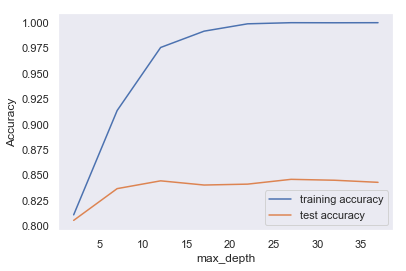

In [131]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


##### Finetuning n_estimators taking max_depth as 7 from above 

In [132]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 800, 100)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=7)

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)

rf.fit(X_train_mju, y_train_mju)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=7,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_s

In [133]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.520621,0.009672,0.013566,0.000489,100,{'n_estimators': 100},0.842415,0.826215,0.839233,0.842183,0.834808,0.836971,0.006038,7,0.910063,0.916697,0.914886,0.911570,0.911570,0.912957,0.002447
1,0.990553,0.017631,0.023937,0.000632,200,{'n_estimators': 200},0.851252,0.833579,0.848083,0.839233,0.821534,0.838736,0.010647,2,0.914117,0.914854,0.915623,0.910464,0.909727,0.912957,0.002396
2,1.473858,0.020080,0.034707,0.000399,300,{'n_estimators': 300},0.849779,0.832106,0.842183,0.837758,0.827434,0.837852,0.007779,6,0.913749,0.912643,0.909359,0.909727,0.909359,0.910967,0.001858
3,1.958760,0.009910,0.047074,0.001466,400,{'n_estimators': 400},0.849779,0.835052,0.842183,0.833333,0.830383,0.838146,0.006995,5,0.910431,0.918540,0.912307,0.908254,0.913043,0.912515,0.003439
4,2.561156,0.040388,0.061437,0.002569,500,{'n_estimators': 500},0.842415,0.837997,0.846608,0.839233,0.825959,0.838442,0.006916,3,0.912274,0.917066,0.912307,0.910833,0.911201,0.912736,0.002242


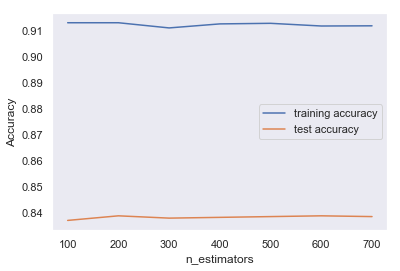

In [134]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Tuning max_features

Let's see how the model performance varies with ```max_features```, which is the maximum numbre of features considered for splitting at a node.

In [135]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [7, 10, 12, 15]}

# instantiate the model
rf = RandomForestClassifier(max_depth=7)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                 return_train_score=True)
rf.fit(X_train_mju, y_train_mju)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=7,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_s

In [136]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.441027,0.020216,0.013165,0.000399,7,{'max_features': 7},0.848306,0.821797,0.842183,0.836283,0.821534,0.834021,0.010781,4,0.905271,0.908588,0.905306,0.906411,0.911201,0.907355,0.002269
1,0.560305,0.008231,0.012963,0.000003,10,{'max_features': 10},0.839470,0.829161,0.837758,0.839233,0.830383,0.835201,0.004488,3,0.913380,0.918909,0.907148,0.911938,0.911938,0.912663,0.003768
2,0.644276,0.001997,0.012767,0.000399,12,{'max_features': 12},0.842415,0.832106,0.845133,0.846608,0.827434,0.838739,0.007591,2,0.913749,0.917803,0.914517,0.914517,0.914149,0.914947,0.001456
3,0.796679,0.015763,0.013162,0.000397,15,{'max_features': 15},0.843888,0.833579,0.842183,0.845133,0.833333,0.839623,0.005122,1,0.918172,0.918909,0.918570,0.917833,0.920781,0.918853,0.001030


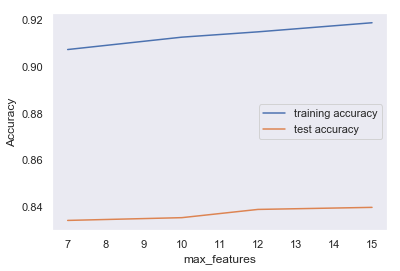

In [137]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### Tuning min_samples_leaf

In [138]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                 return_train_score=True)
rf.fit(X_train_mju, y_train_mju)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [139]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.334901,0.014335,0.012567,0.000798,100,{'min_samples_leaf': 100},0.811487,0.795287,0.821534,0.814159,0.806785,0.809851,0.008709,1,0.822337,0.829340,0.821297,0.826455,0.826824,0.825251,0.002992
1,0.290822,0.007689,0.012766,0.000399,150,{'min_samples_leaf': 150},0.810015,0.787923,0.827434,0.811209,0.806785,0.808673,0.012604,2,0.819388,0.823074,0.820929,0.814665,0.817244,0.819060,0.002910
2,0.265499,0.018015,0.012167,0.000399,200,{'min_samples_leaf': 200},0.808542,0.784978,0.805310,0.806785,0.802360,0.801595,0.008552,3,0.805381,0.813859,0.810612,0.810243,0.810980,0.810215,0.002734
3,0.225382,0.000904,0.011577,0.000494,250,{'min_samples_leaf': 250},0.795287,0.770250,0.812684,0.808260,0.797935,0.796883,0.014779,5,0.797641,0.810910,0.806559,0.806927,0.805822,0.805572,0.004342
4,0.206854,0.002152,0.011170,0.000401,300,{'min_samples_leaf': 300},0.793814,0.771723,0.815634,0.808260,0.800885,0.798063,0.015050,4,0.797272,0.800958,0.806559,0.800663,0.800295,0.801149,0.003010


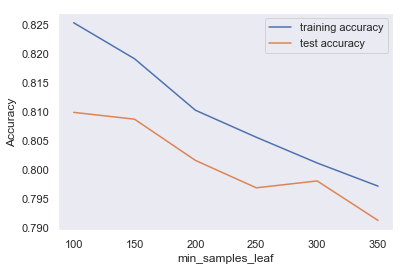

In [140]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### Tuning min_samples_split

Let's now look at the performance of the ensemble as we vary min_samples_split.

In [141]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier()

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                 return_train_score=True)
rf.fit(X_train_mju, y_train_mju)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [142]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.603193,0.009965,0.013566,0.000489,200,{'min_samples_split': 200},0.837997,0.820324,0.831858,0.817109,0.828909,0.827239,0.007620,1,0.854405,0.856985,0.852616,0.853721,0.859985,0.855542,0.002646
1,0.557117,0.017641,0.012964,0.000632,250,{'min_samples_split': 250},0.826215,0.817378,0.836283,0.827434,0.821534,0.825769,0.006354,2,0.845558,0.848507,0.844141,0.850405,0.858143,0.849351,0.004912
2,0.492076,0.014756,0.012973,0.000015,300,{'min_samples_split': 300},0.829161,0.808542,0.833333,0.828909,0.821534,0.824296,0.008746,3,0.843715,0.847033,0.841931,0.847458,0.852248,0.846477,0.003546
3,0.543740,0.136604,0.019947,0.008415,350,{'min_samples_split': 350},0.826215,0.805596,0.842183,0.811209,0.827434,0.822527,0.012952,4,0.837449,0.843715,0.840088,0.842668,0.843405,0.841465,0.002379
4,0.617150,0.078051,0.017952,0.004136,400,{'min_samples_split': 400},0.818851,0.811487,0.828909,0.812684,0.818584,0.818103,0.006175,5,0.835238,0.841135,0.832719,0.840825,0.845984,0.839180,0.004693


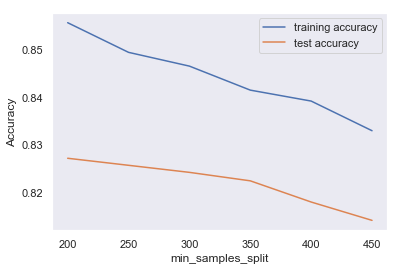

In [143]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Grid Search to Find Optimal Hyperparameters

In [144]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [5,7,10],
    'min_samples_leaf': range(100, 400, 50),
    'min_samples_split': range(100, 300, 50),
    'n_estimators': [100,200, 300], 
    'max_features': [12, 15, 18]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [145]:
# Fit the grid search to the data
grid_search.fit(X_train_mju, y_train_mju)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed:  4.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [146]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8077825507486783 using {'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 100, 'min_samples_split': 100, 'n_estimators': 200}


**Fitting the final model with the best parameters obtained from grid search.**

In [147]:
# model with the best hyperparameters
rft = RandomForestClassifier(bootstrap=True, 
                             max_depth=7, 
                             min_samples_leaf=100,
                             min_samples_split=100, 
                             max_features=18, 
                             n_estimators=100)
# fit
rft.fit(X_train_mju, y_train_mju)

# predict
y_pred_rf = rft.predict(X_test)

print(accuracy_score(y_test,y_pred_rf))

0.8193483597411292


In [148]:
rf_confusion_matrix = confusion_matrix(y_test, y_pred_rf)

printMetrics(y_test, y_pred_rf)

Confusion Matrix: 
 [[6758 1475]
 [ 144  585]]
Sensitivity:  0.8024691358024691
Specificity:  0.8208429491072513
AUC Score:  0.8116560424548602
Precision:  0.28398058252427183
f1 Score:  0.41950519899605593


In [149]:
# Putting features
features = list(X_train_mju.columns[0:])

# If you're on windows:
# Specifing path for dot file.

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/release/bin/'
newpath = r'Visualization/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
# plotting tree with max_depth=7
# Extract single tree into pdfs
for i in range(0,100):
    dot_data = StringIO()  
    estimator = rft.estimators_[i]
    export_graphviz(estimator, out_file=dot_data,
                    feature_names=features, filled=True,rounded=True)

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_pdf("Visualization/dt_mobilechurn_tree_"+str(i)+".pdf")

#### Driver variable analysis from decision trees
Upon analysis of the multiple decision trees that are generated to create the random forest. The following variables are identified to be driver variables of high importance that appear frequently on higher branches of the tree

- total_rech_num_act_ph
- total_rech_amt_act_ph
- arpu_act_ph
- last_day_rch_amt_act_ph

Of the various mous - Lower value of the following mous indicate a good probability to churn

- loc_ic mous
- loc_og mous


## Model 3: Xtreme Gradient Boosting Model

In [150]:
#first build default xgboost model using RandomizedSearchCV and find the best parameter
from sklearn.model_selection import RandomizedSearchCV
random_xgb_model = XGBClassifier()
random_xgb_model = RandomizedSearchCV(random_xgb_model,
                                   param_distributions=param_grid,
                                  n_iter=5,
                                  scoring='roc_auc',
                                  n_jobs=-1,
                                  cv=5,
                                  verbose=3)
random_xgb_model.fit(X_train_mju,y_train_mju)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   32.8s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   36.2s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_i

In [151]:
random_xgb_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7, max_features=18,
              min_child_weight=1, min_samples_leaf=100, min_samples_split=100,
              missing=None, n_estimators=300, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [152]:
# check the best parameters
random_xgb_model.best_params_

{'n_estimators': 300,
 'min_samples_split': 100,
 'min_samples_leaf': 100,
 'max_features': 18,
 'max_depth': 7}

In [153]:
# first build default xgboost model
XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8, seed=None,
              silent=None, subsample=1, verbosity=1)

XGB.fit(X_train_mju,y_train_mju)

y_pred_xgb =  XGB.predict(X_test)

In [154]:
# first build default xgboost model using GridSearchCV
XGB = XGBClassifier()

XGB.fit(X_train_mju,y_train_mju)

y_pred_xgb =  XGB.predict(X_test)

In [155]:
# creating a KFold cross validation 
folds = 5

# specify range of hyperparameters
param_grid = {'scale_pos_weight': [1.8,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89]}

# specify model
xgb_model = XGBClassifier(max_depth=3, n_estimators=100)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'f1', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,n_jobs=3)  

In [156]:
# fit the model
model_cv.fit(X_train_mju, y_train_mju)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   24.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   28.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=3,
             param_grid={'scale_pos_weight': [1.8, 1.81, 1.82, 1.83, 1.84, 1.85,
                                              1.86, 1.87, 1.88, 1.89]},
             pre_dispatch='

In [157]:
# check the best parameters
model_cv.best_params_

{'scale_pos_weight': 1.83}

In [158]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.1,
          'max_depth': 3, 
          'n_estimators':100,
          'subsample':1,
         'objective':'binary:logistic',
          'scale_pos_weight': 1.81}

# fit model on training data
XGB = XGBClassifier(params = params)
XGB.fit(X_train_mju,y_train_mju)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100,
                      'objective': 'binary:logistic', 'scale_pos_weight': 1.81,
                      'subsample': 1},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [159]:
# check the preddiction
y_pred_xgb =  XGB.predict(X_test)

xg_confusion_matrix = confusion_matrix(y_test,y_pred_xgb)
printMetrics(y_test,y_pred_xgb)

Confusion Matrix: 
 [[7038 1195]
 [ 100  629]]
Sensitivity:  0.8628257887517147
Specificity:  0.8548524231750273
AUC Score:  0.858839105963371
Precision:  0.34484649122807015
f1 Score:  0.49275362318840576


In [160]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Summary of prediction models


## Below is the summary of the model scores obtained:

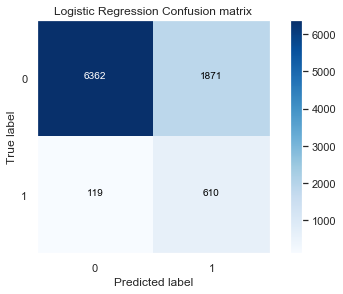

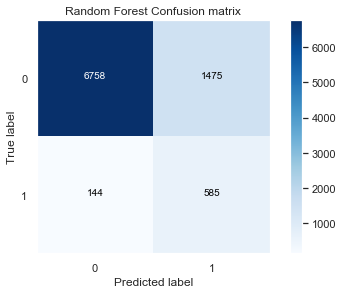

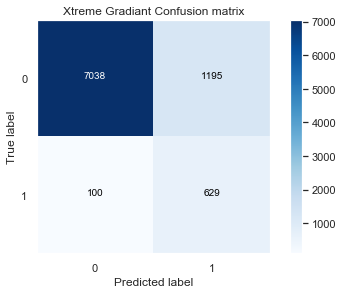

In [161]:
class_names = [0,1]
plt.figure()
plot_confusion_matrix(lr_confusion_matrix , classes=class_names, title='Logistic Regression Confusion matrix')
plt.show()

class_names = [0,1]
plt.figure()
plot_confusion_matrix(rf_confusion_matrix , classes=class_names, title='Random Forest Confusion matrix')
plt.show()

class_names = [0,1]
plt.figure()
plot_confusion_matrix(xg_confusion_matrix , classes=class_names, title='Xtreme Gradiant Confusion matrix')
plt.show()


### Hence, we are inferring the following statement from the modeling & summary provided above:

### In Xtreme Gradient Boosting Model - 3, there is lower in-accurate recommendation of "Churn" customers to be "Non-Churn" and vice versa compared to other models developed.  

### Driver variable understanding using simple Logistic Regression

In [162]:
logreg = LogisticRegression()
rfe = RFE(logreg, 10)             # running RFE with 20 variables as output
rfe = rfe.fit(X_train, y_train)

In [163]:
cols = X_train.columns[rfe.support_].values.tolist()
cols.append('churn')

In [164]:
telecom_rfe_data = pd.concat([X_scaled,y],axis=1)
telecom_rfe_data = telecom_rfe_data[cols]

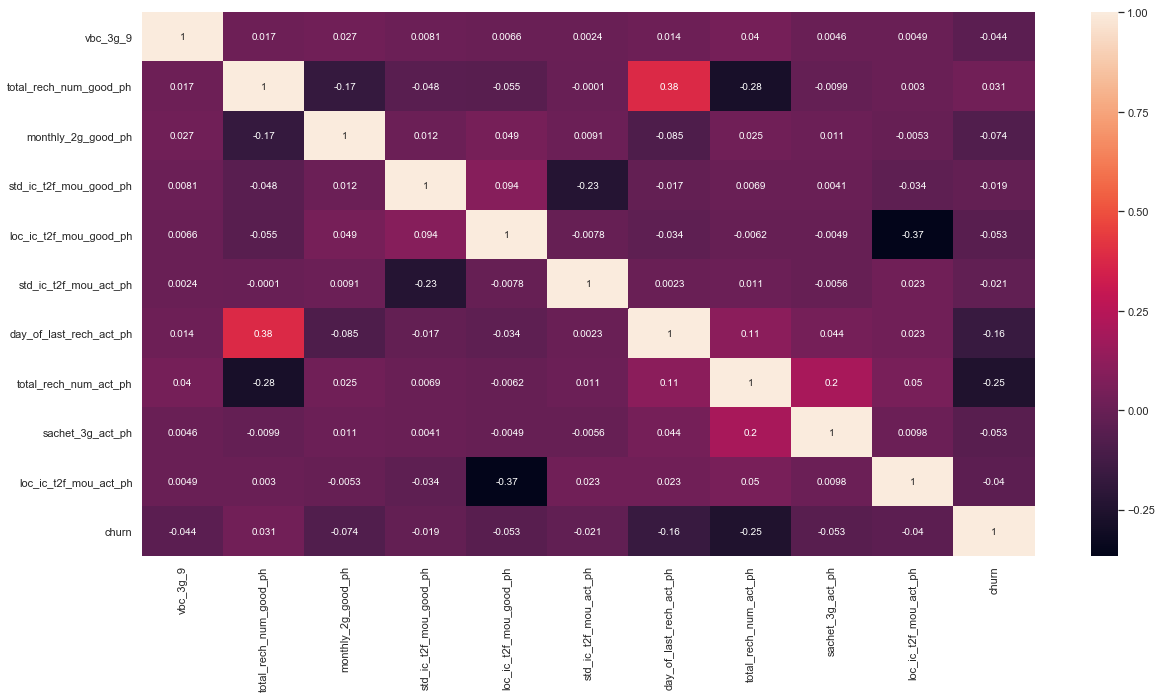

In [165]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(telecom_rfe_data.corr(),annot = True)
plt.show()

In [166]:
# Check for the VIF values of the feature variables. 

cols.remove('churn')
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,day_of_last_rech_act_ph,4.07
1,total_rech_num_good_ph,3.71
4,loc_ic_t2f_mou_good_ph,1.32
2,monthly_2g_good_ph,1.25
7,total_rech_num_act_ph,1.23
9,loc_ic_t2f_mou_act_ph,1.16
3,std_ic_t2f_mou_good_ph,1.07
8,sachet_3g_act_ph,1.05
0,vbc_3g_9,1.03
5,std_ic_t2f_mou_act_ph,1.03


In [167]:
cols.remove('day_of_last_rech_act_ph')

In [168]:
X_train_sm = sm.add_constant(X_train[cols])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20909
Model:                            GLM   Df Residuals:                    20899
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4659.5
Date:                Mon, 30 Dec 2019   Deviance:                       9319.1
Time:                        18:01:41   Pearson chi2:                 3.81e+07
No. Iterations:                    11   Covariance Type:             nonrobust
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.4046      0.056    -25.279      0.000      -1.514      -1.296
vbc_3g_9                  -0.0804      0.016     -5.044      0.000      -0.112      -0.049
total_rech_num_good_ph    -0.1180      0.006    -19.313      0.000      -0.130      -0.106
monthly_2g_good_ph        -0.9946      0.104     -9.537      0.000      -1.199      -0.790
std_ic_t2f_mou_good_ph    -0.0620      0.013     -4.891      0.000      -0.087      -0.037
loc_ic_t2f_mou_good_ph    -0.0569      0.005    -12.616      0.000      -0.066      -0.048
std_ic_t2f_mou_act_ph     -0.0707      0.014     -5.192      0.000      -0.097      -0.044
total_rech_num_act_ph     -0.2073      0.007    -29.776      0.000      -0.221      -0.194
sachet_3g_act_ph          -0.1137      0.038     -2.954      0.003      -0.189      -0.038
loc_ic_t2f_mou_act_ph     -0.0613      0.005    -12.820      0.000      -0.071      -0.052
==========================================================================================
"""

In [169]:
y_train_pred_driver = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_dr = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred_driver})
y_train_pred_dr['final_predicted'] = y_train_pred_dr.Churn_Prob.map( lambda x: 1 if x > 0.51 else 0)
# Let's check the overall accuracy for our driver analysis model
print(round(accuracy_score(y_train_pred_dr.Churn, y_train_pred_dr.final_predicted),2))

0.92


In [170]:
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,total_rech_num_good_ph,1.30
4,loc_ic_t2f_mou_good_ph,1.26
6,total_rech_num_act_ph,1.22
8,loc_ic_t2f_mou_act_ph,1.16
2,monthly_2g_good_ph,1.09
3,std_ic_t2f_mou_good_ph,1.06
7,sachet_3g_act_ph,1.05
5,std_ic_t2f_mou_act_ph,1.03
0,vbc_3g_9,1.02


### DRIVER VARIABLES - Logistic Regression and Decision Trees of Random Forests

The important driver variables considering logistic regression

- total_rech_num_good_ph
- monthly_2g_good_ph
- loc_ic_t2f_mou_good_ph	
- sachet_3g_act_ph


Consolidating the driver variable analysis from both logistic regression and decision trees that constitute random forests we can conclude the following factors highly influence churn


- Recharge amount - total_rech_num_good_ph, total_rech_num_act_ph, total_rech_amt_act_ph with lower values indicate higher probability of churn. Therefore providing better value recharge packages would be recommended.
- LOC Mous like loc_ic_t2f_mou_good_ph - More local calls indicate lower possibility of churn. Therefore lower tarriffs for local calls or providing customer offers on local calls is recommended
- 3g data variables like sachet_3g_act_ph - Lower tariffs on data usage is recommended as well.

# Recommendations to reduce Customer Churn

Based on modeling an EDA following are our recommendations to reduce customer churn:

* **Privilege Customer offers**: for customer who are staying longer with network to increase customer loyalty to the telecom operator.
* **Lower roaming charges** as this is one of the reasons for pre-paid customers to seek out local operators when on roaming.
* **Lower tariffs on data usage**,a better 2G area coverage where 3G is not available.
* **Lower tariffs on local calls and better talktime and data recharge packages**,a better choice of recharge packages on data as well as talktime would cause fewer customers to churn
* **Expansion of 3G network** where 3G is currently not available.
* **Customized pre-paid plan offers**: Continuous monitoring of behavioural signs listed above in action phase to offer customized pe-paid plans to customers, for example customized plans based on where customer minutes of usage (mou) are higher (outgoing/std/t2t/t2m etc).